## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---

## Import Packages

In [41]:
import numpy as np #for numerical operations
import cv2 #for opencv related operations
import pickle #for dumping data
import glob #for file operations
from moviepy.editor import VideoFileClip #for video editing
from IPython.display import HTML #for video displaying on the HTML platform
import matplotlib.pyplot as plt #for image plotting and visualization
from ipywidgets import interact, interactive, fixed #HTML widgets for POC visualization and threshold setting

%matplotlib inline

print('Import Successful...!!!')

Import Successful...!!!


## Camera Calibration

camera calibration successful...!


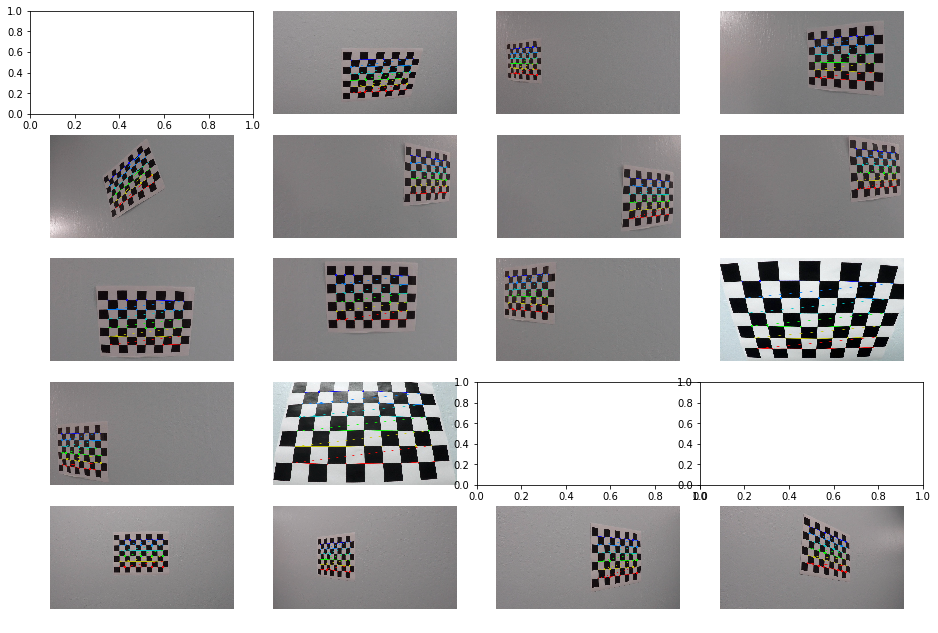

In [42]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# termination criteria
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('./camera_cal/*.jpg')

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

# Step through the list and search for chessboard corners
for i, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)

        # this step to refine image points was taken from:
        # http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
        imgpoints.append(corners2)
    
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        axs[i].axis('off')
        axs[i].imshow(img)
        
print('camera calibration successful...!')

## Undistortion or Image Rectification

Image Rectification successful...!


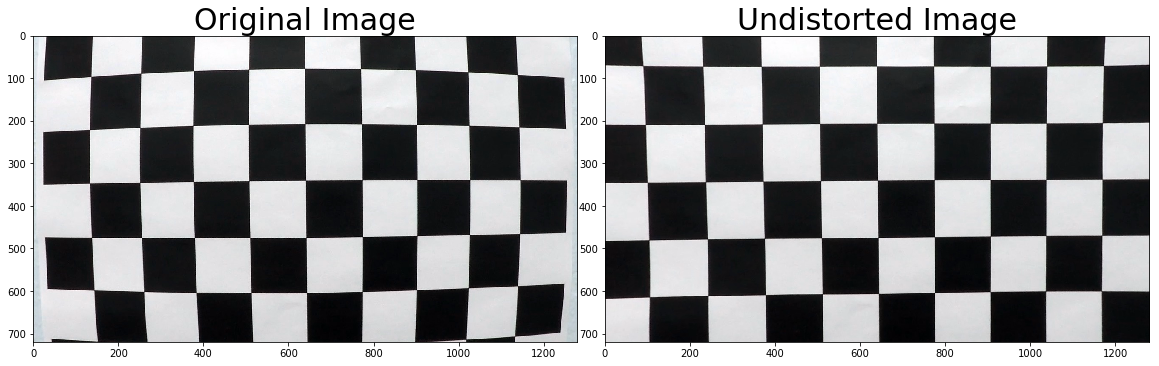

In [43]:
# Test undistortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])
#print(img.shape)
# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
dst = cv2.undistort(img, mtx, dist, None, mtx)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "calibration.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
print('Image Rectification successful...!')

...


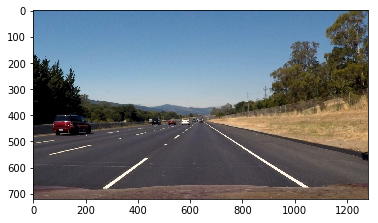

In [44]:
'''
import cv2
vidcap = cv2.VideoCapture('challenge_video.mp4')
success,image = vidcap.read()
count = 0
while success:
  cv2.imwrite("./frames/frame%d.jpg" % count, image)     # save frame as JPEG file      
  success,image = vidcap.read()
  print('Read a new frame: ', success)
  count += 1
'''


# Choose an image from which to build and demonstrate each step of the pipeline
exampleImg = cv2.imread('./test_images/Challenge.jpg')
exampleImg = cv2.imread('./test_images/straight_lines2.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
plt.imshow(exampleImg)
print('...')

## Undistortion on Original Image

In [45]:
# undistort image using camera calibration matrix from above
def undistort(img):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
print('...')

...


...


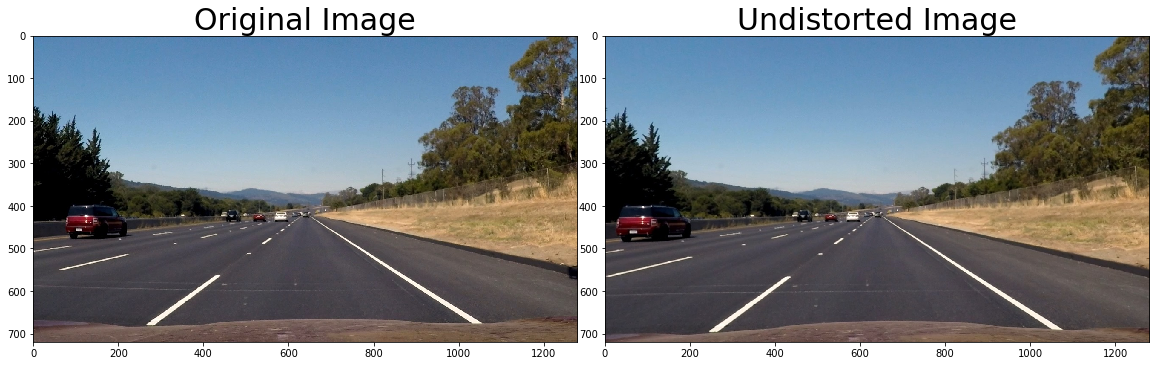

In [46]:
exampleImg_undistort = undistort(exampleImg)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(exampleImg_undistort)
ax2.set_title('Undistorted Image', fontsize=30)

print('...')

## Perspective Transformation

In [47]:
def unwarp(img, src, dst):
    h,w = img.shape[:2]
    # use cv2.getPerspectiveTransform() to get M, the transform matrix, and Minv, the inverse
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    # use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv
print('...')

...


...


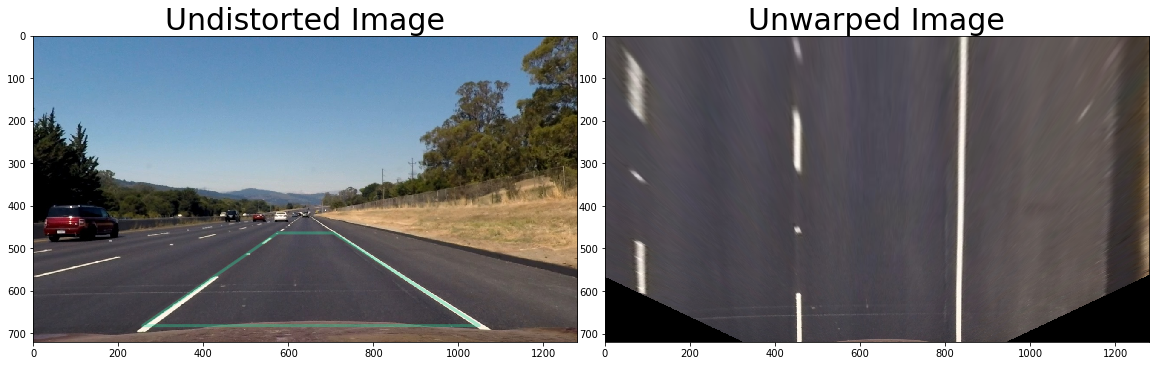

In [48]:
h,w = exampleImg_undistort.shape[:2]

# define source and destination points for transform
src = np.float32([(575,464),
                  (707,464), 
                  (258,682), 
                  (1049,682)])
dst = np.float32([(450,0),
                  (w-450,0),
                  (450,h),
                  (w-450,h)])

exampleImg_unwarp, M, Minv = unwarp(exampleImg_undistort, src, dst)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(exampleImg_undistort)
x = [src[0][0],src[2][0],src[3][0],src[1][0],src[0][0]]
y = [src[0][1],src[2][1],src[3][1],src[1][1],src[0][1]]
ax1.plot(x, y, color='#33cc99', alpha=0.4, linewidth=3, solid_capstyle='round', zorder=2)
ax1.set_ylim([h,0])
ax1.set_xlim([0,w])
ax1.set_title('Undistorted Image', fontsize=30)
ax2.imshow(exampleImg_unwarp)
ax2.set_title('Unwarped Image', fontsize=30)

print('...')

...


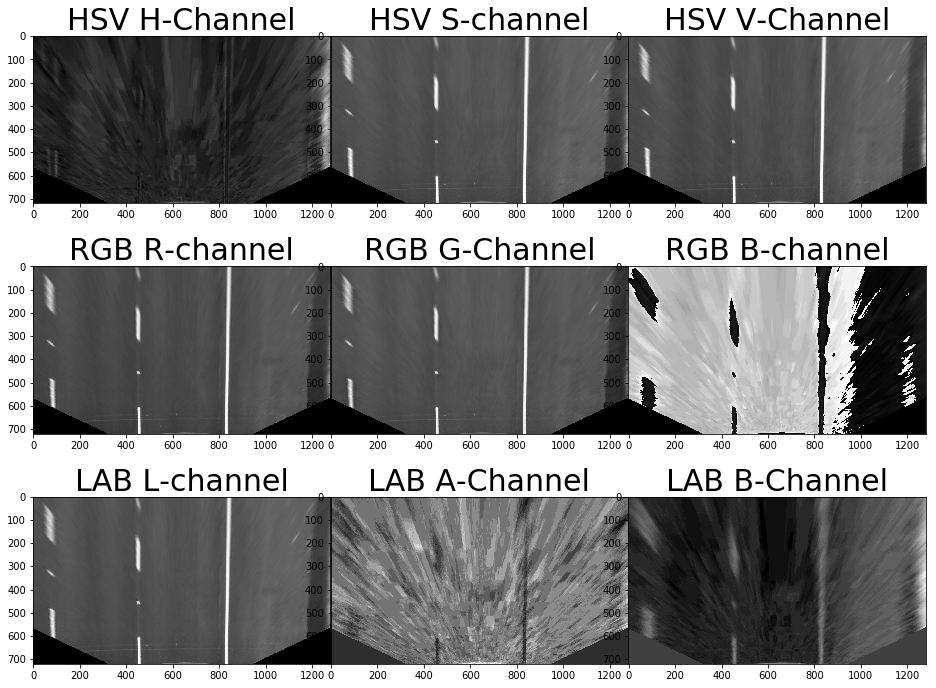

In [49]:
#Visualize multiple color space channels
exampleImg_unwarp_R = exampleImg_unwarp[:,:,0]
exampleImg_unwarp_G = exampleImg_unwarp[:,:,1]
exampleImg_unwarp_B = exampleImg_unwarp[:,:,2]
exampleImg_unwarp_HSV = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2HSV)
exampleImg_unwarp_H = exampleImg_unwarp_HSV[:,:,0]
exampleImg_unwarp_S = exampleImg_unwarp_HSV[:,:,1]
exampleImg_unwarp_V = exampleImg_unwarp_HSV[:,:,2]
exampleImg_unwarp_LAB = cv2.cvtColor(exampleImg_unwarp, cv2.COLOR_RGB2Lab)
exampleImg_unwarp_L = exampleImg_unwarp_LAB[:,:,0]
exampleImg_unwarp_A = exampleImg_unwarp_LAB[:,:,1]
exampleImg_unwarp_B2 = exampleImg_unwarp_LAB[:,:,2]
fig, axs = plt.subplots(3,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].set_title('HSV H-Channel', fontsize=30)
axs[0].imshow(exampleImg_unwarp_S, cmap='gray')
axs[1].set_title('HSV S-channel', fontsize=30)
axs[1].imshow(exampleImg_unwarp_V, cmap='gray')
axs[2].set_title('HSV V-Channel', fontsize=30)
axs[2].imshow(exampleImg_unwarp_R, cmap='gray')
axs[3].set_title('RGB R-channel', fontsize=30)
axs[3].imshow(exampleImg_unwarp_G, cmap='gray')
axs[4].set_title('RGB G-Channel', fontsize=30)
axs[4].imshow(exampleImg_unwarp_B, cmap='gray')
axs[5].set_title('RGB B-channel', fontsize=30)
axs[5].imshow(exampleImg_unwarp_H, cmap='gray')
axs[6].imshow(exampleImg_unwarp_L, cmap='gray')
axs[6].set_title('LAB L-channel', fontsize=30)
axs[7].imshow(exampleImg_unwarp_A, cmap='gray')
axs[7].set_title('LAB A-Channel', fontsize=30)
axs[8].imshow(exampleImg_unwarp_B2, cmap='gray')
axs[8].set_title('LAB B-Channel', fontsize=30)
print('...')

## Sobel Edge Detection

In [50]:
# Define a function that applies Sobel x or y, 
# then takes an absolute value and applies a threshold.
def abs_sobel_thresh(img, orient='x', thresh_min=25, thresh_max=255):
    # Apply the following steps to img
    # 1) Convert to grayscale === or LAB L channel
    gray = (cv2.cvtColor(img, cv2.COLOR_RGB2Lab))[:,:,0]
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as your binary_output image
    binary_output = sxbinary # Remove this line
    return binary_output
print('...')

...


In [51]:
'''
def update(min_thresh, max_thresh):
    exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh)
    # Visualize sobel absolute threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelAbs, cmap='gray')
    ax2.set_title('Sobel Absolute', fontsize=30)

interact(update, 
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')
'''

"\ndef update(min_thresh, max_thresh):\n    exampleImg_sobelAbs = abs_sobel_thresh(exampleImg_unwarp, 'x', min_thresh, max_thresh)\n    # Visualize sobel absolute threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_sobelAbs, cmap='gray')\n    ax2.set_title('Sobel Absolute', fontsize=30)\n\ninteract(update, \n         min_thresh=(0,255), \n         max_thresh=(0,255))\n\nprint('...')\n"

## Sobel Magnitude Calculation

In [52]:
# Define a function that applies Sobel x and y, 
# then computes the magnitude of the gradient
# and applies a threshold
def mag_thresh(img, sobel_kernel=25, mag_thresh=(25, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Calculate the magnitude 
    mag_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*mag_sobel/np.max(mag_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    binary_output = np.copy(sxbinary) 
    return binary_output
print('...')

...


In [53]:
'''
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel magnitude threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelMag, cmap='gray')
    ax2.set_title('Sobel Magnitude', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,255), 
                 max_thresh=(0,255))

print('...')
'''

"\ndef update(kernel_size, min_thresh, max_thresh):\n    exampleImg_sobelMag = mag_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))\n    # Visualize sobel magnitude threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_sobelMag, cmap='gray')\n    ax2.set_title('Sobel Magnitude', fontsize=30)\n\ninteract(update, kernel_size=(1,31,2), \n                 min_thresh=(0,255), \n                 max_thresh=(0,255))\n\nprint('...')\n"

## Sobel Direction Calculation

In [54]:
# Define a function that applies Sobel x and y, 
# then computes the direction of the gradient
# and applies a threshold.
def dir_thresh(img, sobel_kernel=7, thresh=(0, 0.09)):    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    grad_dir = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    binary_output =  np.zeros_like(grad_dir)
    binary_output[(grad_dir >= thresh[0]) & (grad_dir <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output
print('...')

...


In [55]:
'''
def update(kernel_size, min_thresh, max_thresh):
    exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))
    # Visualize sobel direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_sobelDir, cmap='gray')
    ax2.set_title('Sobel Direction', fontsize=30)

interact(update, kernel_size=(1,31,2), 
                 min_thresh=(0,np.pi/2,0.01), 
                 max_thresh=(0,np.pi/2,0.01))

print('...')
'''

"\ndef update(kernel_size, min_thresh, max_thresh):\n    exampleImg_sobelDir = dir_thresh(exampleImg_unwarp, kernel_size, (min_thresh, max_thresh))\n    # Visualize sobel direction threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_sobelDir, cmap='gray')\n    ax2.set_title('Sobel Direction', fontsize=30)\n\ninteract(update, kernel_size=(1,31,2), \n                 min_thresh=(0,np.pi/2,0.01), \n                 max_thresh=(0,np.pi/2,0.01))\n\nprint('...')\n"

## Sobel Magnitude and Direction

In [56]:
def update(mag_kernel_size, mag_min_thresh, mag_max_thresh, dir_kernel_size, dir_min_thresh, dir_max_thresh):
    exampleImg_sobelMag2 = mag_thresh(exampleImg_unwarp, mag_kernel_size, (mag_min_thresh, mag_max_thresh))
    exampleImg_sobelDir2 = dir_thresh(exampleImg_unwarp, dir_kernel_size, (dir_min_thresh, dir_max_thresh))
    combined = np.zeros_like(exampleImg_sobelMag2)
    combined[((exampleImg_sobelMag2 == 1) & (exampleImg_sobelDir2 == 1))] = 1
    # Visualize sobel magnitude + direction threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(combined, cmap='gray')
    ax2.set_title('Sobel Magnitude + Direction', fontsize=30)
'''
interact(update, mag_kernel_size=(1,31,2), 
                 mag_min_thresh=(0,255), 
                 mag_max_thresh=(0,255),
                 dir_kernel_size=(1,31,2), 
                 dir_min_thresh=(0,np.pi/2,0.01), 
                 dir_max_thresh=(0,np.pi/2,0.01))

print('...')
'''

"\ninteract(update, mag_kernel_size=(1,31,2), \n                 mag_min_thresh=(0,255), \n                 mag_max_thresh=(0,255),\n                 dir_kernel_size=(1,31,2), \n                 dir_min_thresh=(0,np.pi/2,0.01), \n                 dir_max_thresh=(0,np.pi/2,0.01))\n\nprint('...')\n"

## HLS colour transform

In [57]:
# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_sthresh(img, thresh=(125, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(hls[:,:,2])
    binary_output[(hls[:,:,2] > thresh[0]) & (hls[:,:,2] <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


In [58]:
'''
def update(min_thresh, max_thresh):
    exampleImg_SThresh = hls_sthresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # Visualize hls s-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_SThresh, cmap='gray')
    ax2.set_title('HLS S-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')
'''

"\ndef update(min_thresh, max_thresh):\n    exampleImg_SThresh = hls_sthresh(exampleImg_unwarp, (min_thresh, max_thresh))\n    # Visualize hls s-channel threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_SThresh, cmap='gray')\n    ax2.set_title('HLS S-Channel', fontsize=30)\n\ninteract(update,\n         min_thresh=(0,255), \n         max_thresh=(0,255))\n\nprint('...')\n"

## HLS colour transform L channel

In [59]:
# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


In [60]:
'''
def update(min_thresh, max_thresh):
    exampleImg_LThresh = hls_lthresh(exampleImg_unwarp, (min_thresh, max_thresh))
    # Visualize hls l-channel threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LThresh, cmap='gray')
    ax2.set_title('HLS L-Channel', fontsize=30)

interact(update,
         min_thresh=(0,255), 
         max_thresh=(0,255))

print('...')
'''

"\ndef update(min_thresh, max_thresh):\n    exampleImg_LThresh = hls_lthresh(exampleImg_unwarp, (min_thresh, max_thresh))\n    # Visualize hls l-channel threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_LThresh, cmap='gray')\n    ax2.set_title('HLS L-Channel', fontsize=30)\n\ninteract(update,\n         min_thresh=(0,255), \n         max_thresh=(0,255))\n\nprint('...')\n"

## LAB colour transform B channel

In [61]:
# Define a function that thresholds the B-channel of LAB
# Use exclusive lower bound (>) and inclusive upper (<=), OR the results of the thresholds (B channel should capture
# yellows)
def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output
print('...')

...


In [62]:
'''
def update(min_b_thresh, max_b_thresh):
    exampleImg_LBThresh = lab_bthresh(exampleImg_unwarp, (min_b_thresh, max_b_thresh))
    # Visualize LAB B threshold
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    ax1.imshow(exampleImg_unwarp)
    ax1.set_title('Unwarped Image', fontsize=30)
    ax2.imshow(exampleImg_LBThresh, cmap='gray')
    ax2.set_title('LAB B-channel', fontsize=30)

interact(update,
         min_b_thresh=(0,255),
         max_b_thresh=(0,255))

print('...')
'''

"\ndef update(min_b_thresh, max_b_thresh):\n    exampleImg_LBThresh = lab_bthresh(exampleImg_unwarp, (min_b_thresh, max_b_thresh))\n    # Visualize LAB B threshold\n    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))\n    f.subplots_adjust(hspace = .2, wspace=.05)\n    ax1.imshow(exampleImg_unwarp)\n    ax1.set_title('Unwarped Image', fontsize=30)\n    ax2.imshow(exampleImg_LBThresh, cmap='gray')\n    ax2.set_title('LAB B-channel', fontsize=30)\n\ninteract(update,\n         min_b_thresh=(0,255),\n         max_b_thresh=(0,255))\n\nprint('...')\n"

## Pipeline for Single Image

In [63]:
# Define the complete image processing pipeline, reads raw image and returns binary image with lane lines identified
# (hopefully)
def pipeline(img):
    # Undistort
    img_undistort = undistort(img)
    
    # Perspective Transform
    img_unwarp, M, Minv = unwarp(img_undistort, src, dst)

    # Sobel Absolute (using default parameters)
    img_sobelAbs = abs_sobel_thresh(img_unwarp)

    # Sobel Magnitude (using default parameters)
    img_sobelMag = mag_thresh(img_unwarp)
    
    # Sobel Direction (using default parameters)
    img_sobelDir = dir_thresh(img_unwarp)
    
    # HLS S-channel Threshold (using default parameters)
    img_SThresh = hls_sthresh(img_unwarp)

    # HLS L-channel Threshold (using default parameters)
    img_LThresh = hls_lthresh(img_unwarp)

    # Lab B-channel Threshold (using default parameters)
    img_BThresh = lab_bthresh(img_unwarp)
    
    # Combine HLS and Lab B channel thresholds
    combined = np.zeros_like(img_BThresh)
    combined[(img_LThresh == 1) | (img_BThresh == 1)] = 1
    #combined[(img_SThresh == 1) | (img_BThresh == 1)] = 1
    #combined[(img_sobelAbs == 1) | (img_sobelDir == 1)] = 1

    return combined, Minv
    
print('...')

...


...


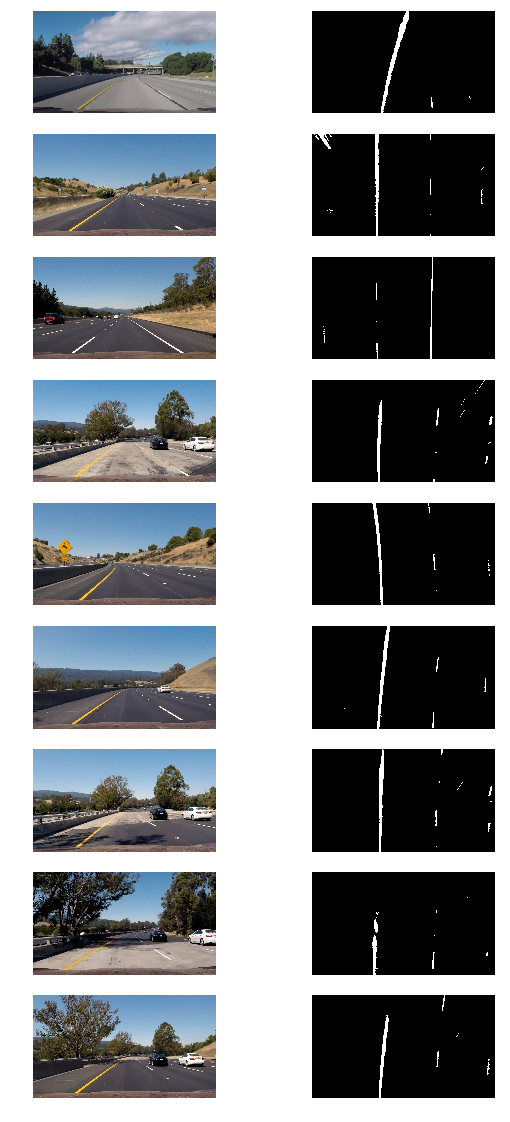

In [64]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
# Set up plot
fig, axs = plt.subplots(len(images),2, figsize=(10, 20))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
                  
i = 0
for image in images:
    img = cv2.imread(image)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_bin, Minv = pipeline(img)
    axs[i].imshow(img)
    axs[i].axis('off')
    i += 1
    axs[i].imshow(img_bin, cmap='gray')
    axs[i].axis('off')
    i += 1

print('...')

## Sliding window Polyfit

In [65]:
# Define method to fit polynomial to binary image with lines extracted, using sliding window
def sliding_window_polyfit(img):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    print(midpoint)
    quarter_point = np.int(midpoint//2)
    print(quarter_point)
    # Previously the left/right base was the max of the left/right half of the histogram
    # this changes it so that only a quarter of the histogram (directly to the left/right) is considered
    leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point
    #quarter_point = 0
    #leftx_base = np.argmax(histogram[quarter_point:midpoint]) + quarter_point

    #print(np.argmax(histogram[quarter_point:midpoint]))
    rightx_base = np.argmax(histogram[midpoint:(midpoint+quarter_point)]) + midpoint
    #rightx_base = np.argmax(histogram[midpoint:]) 

    #print(np.argmax(histogram[midpoint:]))
    
    print('base pts:', leftx_base, rightx_base)

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    #print(nonzerox,nonzeroy)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 80
    # Set minimum number of pixels found to recenter window
    minpix = 40
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    # Rectangle data for visualization
    rectangle_data = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = (img.shape[0] - (window+1)*window_height) + 1
        win_y_high = (img.shape[0] - window*window_height) + 1
        #print(win_y_low,win_y_high)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        #print(window,win_xleft_low,win_xleft_high)
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        rectangle_data.append((win_y_low, win_y_high, win_xleft_low, win_xleft_high, win_xright_low, win_xright_high))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        #print(good_left_inds)
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
    
    visualization_data = (rectangle_data, histogram)
    
    return left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data

    
    

## Sliding window visualization

640
320
base pts: 442 849
Sliding window plotting successful..!


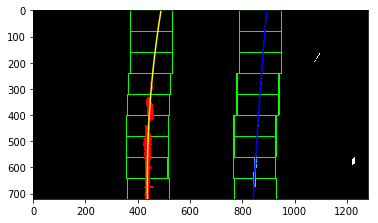

In [66]:
# visualize the result on example image
exampleImg = cv2.imread('./test_images/test5.jpg')
exampleImg = cv2.cvtColor(exampleImg, cv2.COLOR_BGR2RGB)
exampleImg_bin, Minv = pipeline(exampleImg)
    
left_fit, right_fit, left_lane_inds, right_lane_inds, visualization_data = sliding_window_polyfit(exampleImg_bin)

h = exampleImg.shape[0]
left_fit_x_int = left_fit[0]*h**2 + left_fit[1]*h + left_fit[2]
right_fit_x_int = right_fit[0]*h**2 + right_fit[1]*h + right_fit[2]
#print('fit x-intercepts:', left_fit_x_int, right_fit_x_int)

rectangles = visualization_data[0]
histogram = visualization_data[1]

# Create an output image to draw on and  visualize the result
out_img = np.uint8(np.dstack((exampleImg_bin, exampleImg_bin, exampleImg_bin))*255)
# Generate x and y values for plotting
#print(exampleImg_bin.shape[0]-1)
ploty = np.linspace(0, exampleImg_bin.shape[0]-1, exampleImg_bin.shape[0] )
#print(ploty)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
for rect in rectangles:
# Draw the windows on the visualization image
    cv2.rectangle(out_img,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 3) 
    cv2.rectangle(out_img,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 3) 
# Identify the x and y positions of all nonzero pixels in the image
nonzero = exampleImg_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [100, 200, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='blue')
plt.xlim(0, 1280)
plt.ylim(720, 0)

print('Sliding window plotting successful..!')

## Histogram Calculation

Histogram plotting successful..!


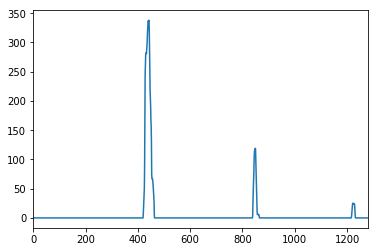

In [67]:

# Print histogram from sliding window polyfit for example image
plt.plot(histogram)
plt.xlim(0, 1280)
print('Histogram plotting successful..!')

## fitting polynomial visualization

In [68]:
# Define method to fit polynomial to binary image based upon a previous fit (chronologically speaking);
# this assumes that the fit will not change significantly from one video frame to the next
def polyfit_using_prev_fit(binary_warped, left_fit_prev, right_fit_prev):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 80
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] - margin)) & 
                      (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] - margin)) & 
                       (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit_new, right_fit_new = (None, None)
    if len(leftx) != 0:
        # Fit a second order polynomial to each
        left_fit_new = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit_new = np.polyfit(righty, rightx, 2)
    return left_fit_new, right_fit_new, left_lane_inds, right_lane_inds
print('...')

...


...


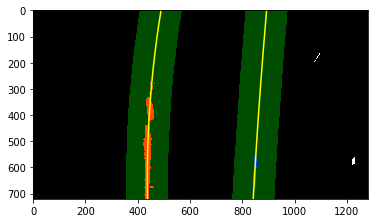

In [69]:
# visualize the result on example image
exampleImg2 = cv2.imread('./test_images/test5.jpg')
exampleImg2 = cv2.cvtColor(exampleImg2, cv2.COLOR_BGR2RGB)
exampleImg2_bin, Minv = pipeline(exampleImg2)   
margin = 80

left_fit2, right_fit2, left_lane_inds2, right_lane_inds2 = polyfit_using_prev_fit(exampleImg2_bin, left_fit, right_fit)

# Generate x and y values for plotting
ploty = np.linspace(0, exampleImg2_bin.shape[0]-1, exampleImg2_bin.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
left_fitx2 = left_fit2[0]*ploty**2 + left_fit2[1]*ploty + left_fit2[2]
right_fitx2 = right_fit2[0]*ploty**2 + right_fit2[1]*ploty + right_fit2[2]

# Create an image to draw on and an image to show the selection window
out_img = np.uint8(np.dstack((exampleImg2_bin, exampleImg2_bin, exampleImg2_bin))*255)
window_img = np.zeros_like(out_img)

# Color in left and right line pixels
nonzero = exampleImg2_bin.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds2], nonzerox[left_lane_inds2]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds2], nonzerox[right_lane_inds2]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area (OLD FIT)
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx2, ploty, color='yellow')
plt.plot(right_fitx2, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
print('...')

## Radius of curvature and distance from lane center estimation

In [70]:

# Method to determine radius of curvature and distance from lane center 
# based on binary image, polynomial fit, and L and R lane pixel indices
def calc_curv_rad_and_center_dist(bin_img, l_fit, r_fit, l_lane_inds, r_lane_inds):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/100 # meters per pixel in y dimension, lane line is 10 ft = 3.048 meters
    xm_per_pix = 3.7/378 # meters per pixel in x dimension, lane width is 12 ft = 3.7 meters
    left_curverad, right_curverad, center_dist = (0, 0, 0)
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    h = bin_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    y_eval = np.max(ploty)
  
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = bin_img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Again, extract left and right line pixel positions
    leftx = nonzerox[l_lane_inds]
    lefty = nonzeroy[l_lane_inds] 
    rightx = nonzerox[r_lane_inds]
    righty = nonzeroy[r_lane_inds]
    
    if len(leftx) != 0 and len(rightx) != 0:
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
    
    # Distance from center is image x midpoint - mean of l_fit and r_fit intercepts 
    if r_fit is not None and l_fit is not None:
        car_position = bin_img.shape[1]/2
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        lane_center_position = (r_fit_x_int + l_fit_x_int) /2
        center_dist = (car_position - lane_center_position) * xm_per_pix
    return left_curverad, right_curverad, center_dist
print('...')

...


In [71]:
rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(exampleImg_bin, left_fit, right_fit, left_lane_inds, right_lane_inds)

print('Radius of curvature for example:', rad_l, 'm,', rad_r, 'm')
print('Distance from lane center for example:', d_center, 'm')

Radius of curvature for example: 375.53524064234665 m, 2167.27979696653 m
Distance from lane center for example: 0.00407763454079426 m


## Drawing Lane based on estimated Data

In [72]:
def draw_lane(original_img, binary_img, l_fit, r_fit, Minv):
    new_img = np.copy(original_img)
    if l_fit is None or r_fit is None:
        return original_img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = binary_img.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    left_fitx = l_fit[0]*ploty**2 + l_fit[1]*ploty + l_fit[2]
    right_fitx = r_fit[0]*ploty**2 + r_fit[1]*ploty + r_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([pts_left]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([pts_right]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result
print('...')

...


...


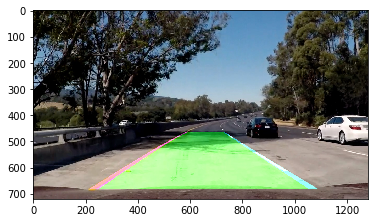

In [73]:
exampleImg_out1 = draw_lane(exampleImg, exampleImg_bin, left_fit, right_fit, Minv)
plt.imshow(exampleImg_out1)
print('...')

In [74]:
def draw_data(original_img, curv_rad, center_dist):
    new_img = np.copy(original_img)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Curve radius: ' + '{:04.2f}'.format(curv_rad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if center_dist > 0:
        direction = 'right'
    elif center_dist < 0:
        direction = 'left'
    abs_center_dist = abs(center_dist)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction + ' of center'
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img
print('...')

...


...


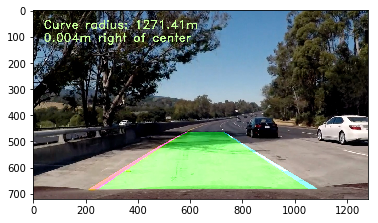

In [75]:
exampleImg_out2 = draw_data(exampleImg_out1, (rad_l+rad_r)/2, d_center)
plt.imshow(exampleImg_out2)
print('...')

## Defining Class for Line Detection

In [76]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        self.px_count = None
    def add_fit(self, fit, inds):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    # throw out old fits, keep newest n
                    self.current_fit = self.current_fit[len(self.current_fit)-5:]
                self.best_fit = np.average(self.current_fit, axis=0)
        # or remove one from the history, if not found
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


            

print('...')

...


## fitting polynomial onto the image

In [77]:
def plot_fit_onto_img(img, fit, plot_color):
    if fit is None:
        return img
    new_img = np.copy(img)
    h = new_img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.array([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(new_img, np.int32([pts]), isClosed=False, color=plot_color, thickness=8)
    return new_img
print('...')

...


## Processing on a single image

In [78]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, Minv = pipeline(new_img)
    
    # if both left and right lines were detected last frame, use polyfit_using_prev_fit, otherwise use sliding window
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds, _ = sliding_window_polyfit(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = polyfit_using_prev_fit(img_bin, l_line.best_fit, r_line.best_fit)
        
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit, l_lane_inds)
    r_line.add_fit(r_fit, r_lane_inds)
    
    # draw the current best fit if it exists
    if l_line.best_fit is not None and r_line.best_fit is not None:
        img_out1 = draw_lane(new_img, img_bin, l_line.best_fit, r_line.best_fit, Minv)
        rad_l, rad_r, d_center = calc_curv_rad_and_center_dist(img_bin, l_line.best_fit, r_line.best_fit, 
                                                               l_lane_inds, r_lane_inds)
        img_out = draw_data(img_out1, (rad_l+rad_r)/2, d_center)
    else:
        img_out = new_img
    
    diagnostic_output = False
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(img_out,(640,360))
        
        # binary overhead view (top right)
        img_bin = np.dstack((img_bin*255, img_bin*255, img_bin*255))
        resized_img_bin = cv2.resize(img_bin,(640,360))
        diag_img[0:360,640:1280, :] = resized_img_bin
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.copy(img_bin)
        for i, fit in enumerate(l_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.current_fit):
            img_bin_fit = plot_fit_onto_img(img_bin_fit, fit, (0,20*i+100,20*i+100))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, l_line.best_fit, (255,255,0))
        img_bin_fit = plot_fit_onto_img(img_bin_fit, r_line.best_fit, (255,255,0))
        diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        
        # diagnostic data (bottom left)
        color_ok = (200,255,155)
        color_bad = (255,155,155)
        font = cv2.FONT_HERSHEY_DUPLEX
        if l_fit is not None:
            text = 'This fit L: ' + ' {:0.6f}'.format(l_fit[0]) + \
                                    ' {:0.6f}'.format(l_fit[1]) + \
                                    ' {:0.6f}'.format(l_fit[2])
        else:
            text = 'This fit L: None'
        cv2.putText(diag_img, text, (40,380), font, .5, color_ok, 1, cv2.LINE_AA)
        if r_fit is not None:
            text = 'This fit R: ' + ' {:0.6f}'.format(r_fit[0]) + \
                                    ' {:0.6f}'.format(r_fit[1]) + \
                                    ' {:0.6f}'.format(r_fit[2])
        else:
            text = 'This fit R: None'
        cv2.putText(diag_img, text, (40,400), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit L: ' + ' {:0.6f}'.format(l_line.best_fit[0]) + \
                                ' {:0.6f}'.format(l_line.best_fit[1]) + \
                                ' {:0.6f}'.format(l_line.best_fit[2])
        cv2.putText(diag_img, text, (40,440), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Best fit R: ' + ' {:0.6f}'.format(r_line.best_fit[0]) + \
                                ' {:0.6f}'.format(r_line.best_fit[1]) + \
                                ' {:0.6f}'.format(r_line.best_fit[2])
        cv2.putText(diag_img, text, (40,460), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Diffs L: ' + ' {:0.6f}'.format(l_line.diffs[0]) + \
                             ' {:0.6f}'.format(l_line.diffs[1]) + \
                             ' {:0.6f}'.format(l_line.diffs[2])
        if l_line.diffs[0] > 0.001 or \
           l_line.diffs[1] > 1.0 or \
           l_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,500), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Diffs R: ' + ' {:0.6f}'.format(r_line.diffs[0]) + \
                             ' {:0.6f}'.format(r_line.diffs[1]) + \
                             ' {:0.6f}'.format(r_line.diffs[2])
        if r_line.diffs[0] > 0.001 or \
           r_line.diffs[1] > 1.0 or \
           r_line.diffs[2] > 100.:
            diffs_color = color_bad
        else:
            diffs_color = color_ok
        cv2.putText(diag_img, text, (40,520), font, .5, diffs_color, 1, cv2.LINE_AA)
        text = 'Good fit count L:' + str(len(l_line.current_fit))
        cv2.putText(diag_img, text, (40,560), font, .5, color_ok, 1, cv2.LINE_AA)
        text = 'Good fit count R:' + str(len(r_line.current_fit))
        cv2.putText(diag_img, text, (40,580), font, .5, color_ok, 1, cv2.LINE_AA)
        
        img_out = diag_img
    return img_out
print('...')

...


## Applying Lane Detection on video

In [79]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

640
320
base pts: 479 861
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [07:44<00:00,  1.92it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 7min 48s


In [80]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'challenge_video_output.mp4'
video_input1 = VideoFileClip('challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

640
320
base pts: 528 838
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


  1%|▍                                         | 5/485 [00:02<03:20,  2.39it/s]

640
320
base pts: 543 836


  1%|▌                                         | 6/485 [00:02<03:13,  2.47it/s]

640
320
base pts: 550 827


 11%|████▍                                    | 53/485 [00:18<02:32,  2.84it/s]

640
320
base pts: 531 791


 11%|████▋                                    | 55/485 [00:19<02:31,  2.85it/s]

640
320
base pts: 320 788


 12%|████▋                                    | 56/485 [00:19<02:31,  2.83it/s]

640
320
base pts: 320 787


 12%|████▊                                    | 57/485 [00:19<02:31,  2.82it/s]

640
320
base pts: 521 789


 12%|█████                                    | 60/485 [00:20<02:27,  2.87it/s]

640
320
base pts: 539 788


 13%|█████▍                                   | 64/485 [00:22<02:24,  2.91it/s]

640
320
base pts: 320 796


 13%|█████▍                                   | 65/485 [00:22<02:23,  2.92it/s]

640
320
base pts: 320 794


 14%|█████▌                                   | 66/485 [00:22<02:25,  2.88it/s]

640
320
base pts: 320 792


 14%|█████▋                                   | 67/485 [00:23<02:25,  2.87it/s]

640
320
base pts: 320 791


 14%|█████▋                                   | 68/485 [00:23<02:30,  2.77it/s]

640
320
base pts: 320 790


 14%|█████▊                                   | 69/485 [00:24<02:33,  2.72it/s]

640
320
base pts: 320 790


 14%|█████▉                                   | 70/485 [00:24<02:36,  2.65it/s]

640
320
base pts: 320 792


 15%|██████                                   | 71/485 [00:24<02:33,  2.70it/s]

640
320
base pts: 511 792


 16%|██████▌                                  | 78/485 [00:27<02:20,  2.90it/s]

640
320
base pts: 320 806


 16%|██████▋                                  | 79/485 [00:27<02:19,  2.90it/s]

640
320
base pts: 320 804


 16%|██████▊                                  | 80/485 [00:28<02:22,  2.85it/s]

640
320
base pts: 320 802


 17%|██████▊                                  | 81/485 [00:28<02:20,  2.87it/s]

640
320
base pts: 320 804


 17%|██████▉                                  | 82/485 [00:28<02:17,  2.92it/s]

640
320
base pts: 320 802


 17%|███████                                  | 83/485 [00:29<02:15,  2.97it/s]

640
320
base pts: 320 801


 17%|███████                                  | 84/485 [00:29<02:17,  2.92it/s]

640
320
base pts: 320 799


 18%|███████▏                                 | 85/485 [00:29<02:15,  2.96it/s]

640
320
base pts: 320 798


 18%|███████▎                                 | 86/485 [00:30<02:12,  3.00it/s]

640
320
base pts: 320 796


 18%|███████▎                                 | 87/485 [00:30<02:11,  3.03it/s]

640
320
base pts: 506 797


 19%|███████▊                                 | 92/485 [00:32<02:11,  3.00it/s]

640
320
base pts: 320 819


 19%|███████▊                                 | 93/485 [00:32<02:11,  2.97it/s]

640
320
base pts: 320 819


 19%|███████▉                                 | 94/485 [00:32<02:09,  3.02it/s]

640
320
base pts: 320 814


 20%|████████                                 | 95/485 [00:33<02:07,  3.05it/s]

640
320
base pts: 320 811


 20%|████████                                 | 96/485 [00:33<02:09,  3.00it/s]

640
320
base pts: 320 807


 20%|████████▏                                | 97/485 [00:33<02:10,  2.97it/s]

640
320
base pts: 320 805


 20%|████████▎                                | 98/485 [00:34<02:09,  2.99it/s]

640
320
base pts: 320 803


 20%|████████▎                                | 99/485 [00:34<02:07,  3.02it/s]

640
320
base pts: 320 803


 21%|████████▏                               | 100/485 [00:34<02:09,  2.98it/s]

640
320
base pts: 560 803


 21%|████████▎                               | 101/485 [00:35<02:11,  2.92it/s]

640
320
base pts: 569 803


 22%|████████▋                               | 106/485 [00:36<02:05,  3.02it/s]

640
320
base pts: 462 822


 22%|████████▊                               | 107/485 [00:37<02:24,  2.62it/s]

640
320
base pts: 320 818


 22%|████████▉                               | 108/485 [00:37<02:22,  2.64it/s]

640
320
base pts: 320 814


 22%|████████▉                               | 109/485 [00:38<02:29,  2.52it/s]

640
320
base pts: 535 811


 23%|█████████▏                              | 112/485 [00:39<02:17,  2.72it/s]

640
320
base pts: 320 807


 23%|█████████▎                              | 113/485 [00:39<02:13,  2.78it/s]

640
320
base pts: 320 808


 24%|█████████▍                              | 114/485 [00:39<02:11,  2.82it/s]

640
320
base pts: 525 808


 25%|█████████▊                              | 119/485 [00:41<02:08,  2.85it/s]

640
320
base pts: 320 818


 25%|█████████▉                              | 120/485 [00:41<02:06,  2.89it/s]

640
320
base pts: 516 814


 25%|█████████▉                              | 121/485 [00:42<02:06,  2.88it/s]

640
320
base pts: 320 814


 25%|██████████                              | 122/485 [00:42<02:05,  2.88it/s]

640
320
base pts: 320 811


 25%|██████████▏                             | 123/485 [00:43<02:06,  2.86it/s]

640
320
base pts: 500 811


 26%|██████████▏                             | 124/485 [00:43<02:07,  2.84it/s]

640
320
base pts: 500 809


 26%|██████████▎                             | 125/485 [00:43<02:11,  2.73it/s]

640
320
base pts: 501 810


 26%|██████████▍                             | 126/485 [00:44<02:29,  2.40it/s]

640
320
base pts: 499 811


 27%|██████████▋                             | 129/485 [00:45<02:40,  2.21it/s]

640
320
base pts: 498 810


 27%|██████████▋                             | 130/485 [00:46<02:51,  2.07it/s]

640
320
base pts: 320 810


 27%|██████████▊                             | 131/485 [00:46<02:49,  2.09it/s]

640
320
base pts: 320 811


 27%|██████████▉                             | 132/485 [00:47<02:48,  2.10it/s]

640
320
base pts: 320 640


 27%|██████████▉                             | 133/485 [00:47<02:47,  2.10it/s]

640
320
base pts: 320 640


 28%|███████████                             | 134/485 [00:48<02:47,  2.10it/s]

640
320
base pts: 320 640


 28%|███████████▏                            | 135/485 [00:48<02:45,  2.11it/s]

640
320
base pts: 320 640


 28%|███████████▏                            | 136/485 [00:49<02:44,  2.12it/s]

640
320
base pts: 320 640


 28%|███████████▎                            | 137/485 [00:49<02:45,  2.10it/s]

640
320
base pts: 320 640


 28%|███████████▍                            | 138/485 [00:50<02:45,  2.10it/s]

640
320
base pts: 320 640


 29%|███████████▍                            | 139/485 [00:50<02:43,  2.11it/s]

640
320
base pts: 320 640


 29%|███████████▌                            | 140/485 [00:51<02:45,  2.08it/s]

640
320
base pts: 320 822


 29%|███████████▋                            | 141/485 [00:51<02:46,  2.07it/s]

640
320
base pts: 320 821


 29%|███████████▋                            | 142/485 [00:52<02:44,  2.09it/s]

640
320
base pts: 320 818


 29%|███████████▊                            | 143/485 [00:52<02:42,  2.11it/s]

640
320
base pts: 320 819


 30%|███████████▉                            | 144/485 [00:52<02:43,  2.08it/s]

640
320
base pts: 320 816


 30%|███████████▉                            | 145/485 [00:53<02:41,  2.10it/s]

640
320
base pts: 320 822


 30%|████████████                            | 146/485 [00:53<02:39,  2.12it/s]

640
320
base pts: 320 821


 30%|████████████                            | 147/485 [00:54<02:38,  2.13it/s]

640
320
base pts: 320 818


 31%|████████████▏                           | 148/485 [00:54<02:40,  2.10it/s]

640
320
base pts: 320 816


 31%|████████████▎                           | 149/485 [00:55<02:38,  2.12it/s]

640
320
base pts: 320 815


 31%|████████████▎                           | 150/485 [00:55<02:37,  2.13it/s]

640
320
base pts: 320 810


 31%|████████████▍                           | 151/485 [00:56<02:36,  2.13it/s]

640
320
base pts: 320 809


 31%|████████████▌                           | 152/485 [00:56<02:40,  2.07it/s]

640
320
base pts: 320 806


 32%|████████████▌                           | 153/485 [00:57<02:39,  2.09it/s]

640
320
base pts: 320 806


 32%|████████████▋                           | 154/485 [00:57<02:38,  2.09it/s]

640
320
base pts: 320 807


 32%|████████████▊                           | 155/485 [00:58<02:37,  2.09it/s]

640
320
base pts: 522 809


 36%|██████████████▍                         | 175/485 [01:05<01:46,  2.90it/s]

640
320
base pts: 471 809


 36%|██████████████▌                         | 176/485 [01:05<01:45,  2.92it/s]

640
320
base pts: 464 810


 36%|██████████████▌                         | 177/485 [01:06<01:45,  2.93it/s]

640
320
base pts: 461 806


 37%|██████████████▋                         | 178/485 [01:06<01:46,  2.87it/s]

640
320
base pts: 454 807


 37%|██████████████▊                         | 179/485 [01:06<01:46,  2.87it/s]

640
320
base pts: 450 804


 37%|██████████████▉                         | 181/485 [01:07<01:41,  3.00it/s]

640
320
base pts: 320 804


 38%|███████████████                         | 182/485 [01:07<01:42,  2.96it/s]

640
320
base pts: 320 801


 38%|███████████████                         | 183/485 [01:08<01:43,  2.91it/s]

640
320
base pts: 320 802


 38%|███████████████▏                        | 184/485 [01:08<01:43,  2.91it/s]

640
320
base pts: 320 801


 38%|███████████████▎                        | 185/485 [01:08<01:43,  2.89it/s]

640
320
base pts: 545 818


 39%|███████████████▌                        | 188/485 [01:09<01:42,  2.89it/s]

640
320
base pts: 320 812


 39%|███████████████▌                        | 189/485 [01:10<01:41,  2.90it/s]

640
320
base pts: 320 809


 39%|███████████████▋                        | 190/485 [01:10<01:40,  2.95it/s]

640
320
base pts: 320 809


 39%|███████████████▊                        | 191/485 [01:10<01:39,  2.95it/s]

640
320
base pts: 320 809


 40%|███████████████▊                        | 192/485 [01:11<01:40,  2.93it/s]

640
320
base pts: 320 806


 40%|███████████████▉                        | 193/485 [01:11<01:39,  2.94it/s]

640
320
base pts: 639 805


 40%|████████████████                        | 194/485 [01:11<01:37,  2.97it/s]

640
320
base pts: 639 802


 40%|████████████████                        | 195/485 [01:12<01:37,  2.97it/s]

640
320
base pts: 639 803


 40%|████████████████▏                       | 196/485 [01:12<01:38,  2.94it/s]

640
320
base pts: 519 802


 41%|████████████████▎                       | 198/485 [01:13<01:35,  3.00it/s]

640
320
base pts: 549 813


 42%|████████████████▋                       | 202/485 [01:14<01:34,  3.00it/s]

640
320
base pts: 320 808


 42%|████████████████▋                       | 203/485 [01:14<01:34,  2.98it/s]

640
320
base pts: 320 805


 42%|████████████████▊                       | 204/485 [01:15<01:35,  2.94it/s]

640
320
base pts: 547 804


 43%|█████████████████▏                      | 208/485 [01:16<01:33,  2.98it/s]

640
320
base pts: 320 803


 43%|█████████████████▏                      | 209/485 [01:17<01:37,  2.84it/s]

640
320
base pts: 320 799


 43%|█████████████████▎                      | 210/485 [01:17<01:35,  2.88it/s]

640
320
base pts: 320 797


 44%|█████████████████▍                      | 211/485 [01:17<01:33,  2.92it/s]

640
320
base pts: 545 795


 44%|█████████████████▌                      | 213/485 [01:18<01:35,  2.86it/s]

640
320
base pts: 543 807


 44%|█████████████████▋                      | 215/485 [01:19<01:35,  2.81it/s]

640
320
base pts: 320 806


 45%|█████████████████▊                      | 216/485 [01:19<01:36,  2.79it/s]

640
320
base pts: 320 806


 45%|█████████████████▉                      | 217/485 [01:19<01:35,  2.80it/s]

640
320
base pts: 320 805


 45%|█████████████████▉                      | 218/485 [01:20<01:33,  2.85it/s]

640
320
base pts: 552 803


 45%|██████████████████▏                     | 220/485 [01:20<01:29,  2.96it/s]

640
320
base pts: 320 801


 46%|██████████████████▏                     | 221/485 [01:21<01:34,  2.80it/s]

640
320
base pts: 320 801


 46%|██████████████████▎                     | 222/485 [01:21<01:32,  2.84it/s]

640
320
base pts: 320 800


 46%|██████████████████▍                     | 223/485 [01:21<01:29,  2.91it/s]

640
320
base pts: 320 799


 46%|██████████████████▍                     | 224/485 [01:22<01:28,  2.94it/s]

640
320
base pts: 320 798


 46%|██████████████████▌                     | 225/485 [01:22<01:29,  2.89it/s]

640
320
base pts: 320 796


 47%|██████████████████▋                     | 226/485 [01:22<01:28,  2.94it/s]

640
320
base pts: 320 806


 47%|██████████████████▋                     | 227/485 [01:23<01:26,  2.97it/s]

640
320
base pts: 320 804


 47%|██████████████████▊                     | 228/485 [01:23<01:25,  2.99it/s]

640
320
base pts: 320 800


 47%|██████████████████▉                     | 229/485 [01:23<01:27,  2.92it/s]

640
320
base pts: 320 800


 47%|██████████████████▉                     | 230/485 [01:24<01:28,  2.90it/s]

640
320
base pts: 320 801


 48%|███████████████████                     | 231/485 [01:24<01:26,  2.94it/s]

640
320
base pts: 320 801


 48%|███████████████████▏                    | 232/485 [01:24<01:24,  2.98it/s]

640
320
base pts: 539 800


 48%|███████████████████▎                    | 234/485 [01:25<01:25,  2.95it/s]

640
320
base pts: 320 800


 48%|███████████████████▍                    | 235/485 [01:26<01:25,  2.92it/s]

640
320
base pts: 320 801


 49%|███████████████████▍                    | 236/485 [01:26<01:24,  2.94it/s]

640
320
base pts: 320 798


 49%|███████████████████▌                    | 237/485 [01:26<01:25,  2.88it/s]

640
320
base pts: 320 796


 49%|███████████████████▋                    | 238/485 [01:27<01:25,  2.89it/s]

640
320
base pts: 514 794


 50%|████████████████████                    | 243/485 [01:28<01:21,  2.97it/s]

640
320
base pts: 552 804


 51%|████████████████████▎                   | 246/485 [01:29<01:21,  2.93it/s]

640
320
base pts: 320 802


 51%|████████████████████▎                   | 247/485 [01:30<01:21,  2.90it/s]

640
320
base pts: 540 803


 52%|████████████████████▌                   | 250/485 [01:31<01:20,  2.91it/s]

640
320
base pts: 320 802


 52%|████████████████████▋                   | 251/485 [01:31<01:20,  2.92it/s]

640
320
base pts: 320 800


 52%|████████████████████▊                   | 252/485 [01:31<01:19,  2.93it/s]

640
320
base pts: 518 801


 53%|█████████████████████                   | 256/485 [01:33<01:18,  2.93it/s]

640
320
base pts: 320 817


 53%|█████████████████████▏                  | 257/485 [01:33<01:17,  2.96it/s]

640
320
base pts: 320 815


 53%|█████████████████████▎                  | 258/485 [01:33<01:16,  2.97it/s]

640
320
base pts: 320 813


 53%|█████████████████████▎                  | 259/485 [01:34<01:15,  3.00it/s]

640
320
base pts: 320 812


 54%|█████████████████████▍                  | 260/485 [01:34<01:16,  2.96it/s]

640
320
base pts: 320 809


 54%|█████████████████████▌                  | 261/485 [01:34<01:15,  2.98it/s]

640
320
base pts: 320 807


 54%|█████████████████████▌                  | 262/485 [01:35<01:13,  3.03it/s]

640
320
base pts: 535 806


 54%|█████████████████████▊                  | 264/485 [01:35<01:13,  3.00it/s]

640
320
base pts: 320 802


 55%|█████████████████████▊                  | 265/485 [01:36<01:13,  3.00it/s]

640
320
base pts: 320 804


 55%|█████████████████████▉                  | 266/485 [01:36<01:12,  3.03it/s]

640
320
base pts: 517 804


 57%|██████████████████████▊                 | 277/485 [01:40<01:10,  2.97it/s]

640
320
base pts: 320 800


 57%|██████████████████████▉                 | 278/485 [01:40<01:10,  2.95it/s]

640
320
base pts: 320 800


 58%|███████████████████████                 | 279/485 [01:41<01:09,  2.95it/s]

640
320
base pts: 320 794


 58%|███████████████████████                 | 280/485 [01:41<01:08,  2.97it/s]

640
320
base pts: 320 794


 58%|███████████████████████▏                | 281/485 [01:41<01:09,  2.94it/s]

640
320
base pts: 320 807


 58%|███████████████████████▎                | 282/485 [01:42<01:08,  2.96it/s]

640
320
base pts: 499 807


 59%|███████████████████████▌                | 285/485 [01:43<01:18,  2.56it/s]

640
320
base pts: 320 809


 59%|███████████████████████▌                | 286/485 [01:43<01:23,  2.38it/s]

640
320
base pts: 549 808


 60%|████████████████████████                | 291/485 [01:46<01:29,  2.16it/s]

640
320
base pts: 320 800


 60%|████████████████████████                | 292/485 [01:46<01:30,  2.13it/s]

640
320
base pts: 320 800


 60%|████████████████████████▏               | 293/485 [01:47<01:31,  2.10it/s]

640
320
base pts: 548 802


 61%|████████████████████████▌               | 298/485 [01:49<01:28,  2.12it/s]

640
320
base pts: 320 809


 62%|████████████████████████▋               | 299/485 [01:50<01:28,  2.10it/s]

640
320
base pts: 320 806


 62%|████████████████████████▋               | 300/485 [01:50<01:27,  2.12it/s]

640
320
base pts: 547 806


 62%|████████████████████████▉               | 303/485 [01:51<01:26,  2.12it/s]

640
320
base pts: 320 802


 63%|█████████████████████████               | 304/485 [01:52<01:25,  2.11it/s]

640
320
base pts: 320 800


 63%|█████████████████████████▏              | 305/485 [01:52<01:24,  2.12it/s]

640
320
base pts: 320 799


 63%|█████████████████████████▏              | 306/485 [01:53<01:24,  2.11it/s]

640
320
base pts: 320 800


 63%|█████████████████████████▎              | 307/485 [01:53<01:23,  2.13it/s]

640
320
base pts: 516 800


 64%|█████████████████████████▋              | 312/485 [01:56<01:21,  2.12it/s]

640
320
base pts: 320 808


 65%|█████████████████████████▊              | 313/485 [01:56<01:20,  2.13it/s]

640
320
base pts: 542 808


 66%|██████████████████████████▏             | 318/485 [01:58<01:02,  2.67it/s]

640
320
base pts: 320 800


 66%|██████████████████████████▎             | 319/485 [01:58<01:01,  2.71it/s]

640
320
base pts: 320 800


 66%|██████████████████████████▍             | 320/485 [01:59<00:59,  2.79it/s]

640
320
base pts: 522 800


 67%|██████████████████████████▊             | 325/485 [02:01<00:54,  2.94it/s]

640
320
base pts: 501 671


 67%|██████████████████████████▉             | 326/485 [02:01<00:56,  2.84it/s]

640
320
base pts: 541 803


 69%|███████████████████████████▌            | 334/485 [02:04<00:50,  3.02it/s]

640
320
base pts: 636 801


 69%|███████████████████████████▋            | 335/485 [02:04<00:51,  2.91it/s]

640
320
base pts: 639 801


 69%|███████████████████████████▋            | 336/485 [02:04<00:51,  2.90it/s]

640
320
base pts: 541 654


 69%|███████████████████████████▊            | 337/485 [02:05<00:57,  2.55it/s]

640
320
base pts: 546 799


 70%|███████████████████████████▉            | 338/485 [02:05<00:56,  2.59it/s]

640
320
base pts: 623 799


 70%|███████████████████████████▉            | 339/485 [02:06<00:57,  2.55it/s]

640
320
base pts: 320 798


 70%|████████████████████████████            | 340/485 [02:06<00:58,  2.47it/s]

640
320
base pts: 626 799


 70%|████████████████████████████            | 341/485 [02:06<00:55,  2.58it/s]

640
320
base pts: 540 798


 71%|████████████████████████████▍           | 345/485 [02:08<00:49,  2.84it/s]

640
320
base pts: 320 798


 71%|████████████████████████████▌           | 346/485 [02:08<00:49,  2.83it/s]

640
320
base pts: 320 794


 72%|████████████████████████████▌           | 347/485 [02:09<00:48,  2.82it/s]

640
320
base pts: 320 790


 72%|████████████████████████████▋           | 348/485 [02:09<00:47,  2.89it/s]

640
320
base pts: 320 793


 72%|████████████████████████████▊           | 349/485 [02:09<00:46,  2.94it/s]

640
320
base pts: 320 792


 72%|████████████████████████████▊           | 350/485 [02:10<00:45,  2.96it/s]

640
320
base pts: 507 793


 73%|█████████████████████████████           | 353/485 [02:11<00:44,  2.97it/s]

640
320
base pts: 525 795


 74%|█████████████████████████████▌          | 359/485 [02:13<00:43,  2.92it/s]

640
320
base pts: 320 793


 74%|█████████████████████████████▋          | 360/485 [02:13<00:42,  2.92it/s]

640
320
base pts: 526 793


 74%|█████████████████████████████▊          | 361/485 [02:13<00:43,  2.84it/s]

640
320
base pts: 320 792


 75%|█████████████████████████████▊          | 362/485 [02:14<00:44,  2.78it/s]

640
320
base pts: 320 793


 75%|█████████████████████████████▉          | 363/485 [02:14<00:43,  2.80it/s]

640
320
base pts: 320 792


 75%|██████████████████████████████          | 364/485 [02:14<00:42,  2.82it/s]

640
320
base pts: 320 792


 75%|██████████████████████████████          | 365/485 [02:15<00:41,  2.87it/s]

640
320
base pts: 530 786


 76%|██████████████████████████████▎         | 367/485 [02:15<00:40,  2.88it/s]

640
320
base pts: 514 786


 76%|██████████████████████████████▍         | 369/485 [02:16<00:39,  2.92it/s]

640
320
base pts: 534 791


 77%|██████████████████████████████▋         | 372/485 [02:17<00:37,  2.98it/s]

640
320
base pts: 510 791


 78%|███████████████████████████████         | 377/485 [02:19<00:36,  2.95it/s]

640
320
base pts: 523 790


 79%|███████████████████████████████▍        | 381/485 [02:20<00:34,  3.00it/s]

640
320
base pts: 320 791


 79%|███████████████████████████████▌        | 382/485 [02:21<00:34,  3.00it/s]

640
320
base pts: 511 791


 79%|███████████████████████████████▋        | 384/485 [02:21<00:35,  2.83it/s]

640
320
base pts: 320 791


 79%|███████████████████████████████▊        | 385/485 [02:22<00:34,  2.86it/s]

640
320
base pts: 320 789


 80%|███████████████████████████████▊        | 386/485 [02:22<00:36,  2.74it/s]

640
320
base pts: 320 785


 80%|███████████████████████████████▉        | 387/485 [02:22<00:35,  2.78it/s]

640
320
base pts: 320 786


 80%|████████████████████████████████        | 388/485 [02:23<00:34,  2.82it/s]

640
320
base pts: 320 788


 80%|████████████████████████████████        | 389/485 [02:23<00:33,  2.87it/s]

640
320
base pts: 320 789


 80%|████████████████████████████████▏       | 390/485 [02:23<00:32,  2.88it/s]

640
320
base pts: 320 791


 81%|████████████████████████████████▏       | 391/485 [02:24<00:32,  2.89it/s]

640
320
base pts: 505 791


 81%|████████████████████████████████▍       | 393/485 [02:25<00:32,  2.83it/s]

640
320
base pts: 320 791


 81%|████████████████████████████████▍       | 394/485 [02:25<00:32,  2.79it/s]

640
320
base pts: 320 791


 81%|████████████████████████████████▌       | 395/485 [02:25<00:31,  2.85it/s]

640
320
base pts: 320 792


 82%|████████████████████████████████▋       | 396/485 [02:26<00:30,  2.89it/s]

640
320
base pts: 320 792


 82%|████████████████████████████████▋       | 397/485 [02:26<00:30,  2.93it/s]

640
320
base pts: 320 792


 82%|████████████████████████████████▊       | 398/485 [02:26<00:29,  2.91it/s]

640
320
base pts: 320 790


 82%|████████████████████████████████▉       | 399/485 [02:27<00:29,  2.93it/s]

640
320
base pts: 320 791


 82%|████████████████████████████████▉       | 400/485 [02:27<00:28,  2.96it/s]

640
320
base pts: 320 792


 83%|█████████████████████████████████       | 401/485 [02:27<00:28,  2.99it/s]

640
320
base pts: 320 794


 83%|█████████████████████████████████▏      | 402/485 [02:28<00:28,  2.91it/s]

640
320
base pts: 320 794


 83%|█████████████████████████████████▏      | 403/485 [02:28<00:28,  2.87it/s]

640
320
base pts: 320 791


 83%|█████████████████████████████████▎      | 404/485 [02:28<00:28,  2.88it/s]

640
320
base pts: 320 791


 84%|█████████████████████████████████▍      | 405/485 [02:29<00:27,  2.89it/s]

640
320
base pts: 511 800


 84%|█████████████████████████████████▋      | 408/485 [02:30<00:26,  2.95it/s]

640
320
base pts: 320 798


 84%|█████████████████████████████████▋      | 409/485 [02:30<00:26,  2.91it/s]

640
320
base pts: 320 799


 85%|█████████████████████████████████▊      | 410/485 [02:30<00:25,  2.91it/s]

640
320
base pts: 523 803


 85%|██████████████████████████████████      | 413/485 [02:31<00:24,  2.92it/s]

640
320
base pts: 320 801


 85%|██████████████████████████████████▏     | 414/485 [02:32<00:24,  2.94it/s]

640
320
base pts: 320 801


 86%|██████████████████████████████████▏     | 415/485 [02:32<00:23,  2.97it/s]

640
320
base pts: 320 801


 86%|██████████████████████████████████▎     | 416/485 [02:32<00:23,  2.99it/s]

640
320
base pts: 320 804


 86%|██████████████████████████████████▍     | 417/485 [02:33<00:23,  2.95it/s]

640
320
base pts: 320 804


 86%|██████████████████████████████████▍     | 418/485 [02:33<00:22,  2.96it/s]

640
320
base pts: 490 804


 86%|██████████████████████████████████▌     | 419/485 [02:33<00:23,  2.87it/s]

640
320
base pts: 539 804


 87%|██████████████████████████████████▉     | 424/485 [02:35<00:21,  2.89it/s]

640
320
base pts: 527 812


 88%|███████████████████████████████████▏    | 426/485 [02:36<00:20,  2.87it/s]

640
320
base pts: 537 812


 88%|███████████████████████████████████▏    | 427/485 [02:36<00:20,  2.79it/s]

640
320
base pts: 542 807


 89%|███████████████████████████████████▋    | 433/485 [02:39<00:18,  2.82it/s]

640
320
base pts: 537 820


 91%|████████████████████████████████████▎   | 441/485 [02:41<00:15,  2.84it/s]

640
320
base pts: 530 806


 91%|████████████████████████████████████▍   | 442/485 [02:42<00:15,  2.73it/s]

640
320
base pts: 525 822


 92%|████████████████████████████████████▌   | 444/485 [02:42<00:14,  2.77it/s]

640
320
base pts: 528 819


 92%|████████████████████████████████████▋   | 445/485 [02:43<00:14,  2.74it/s]

640
320
base pts: 519 817


 92%|████████████████████████████████████▊   | 446/485 [02:43<00:14,  2.72it/s]

640
320
base pts: 521 816


 92%|████████████████████████████████████▉   | 448/485 [02:44<00:13,  2.73it/s]

640
320
base pts: 534 820


 97%|██████████████████████████████████████▊ | 470/485 [02:52<00:07,  2.10it/s]

640
320
base pts: 526 833


 97%|██████████████████████████████████████▊ | 471/485 [02:53<00:06,  2.02it/s]

640
320
base pts: 529 833


 98%|███████████████████████████████████████ | 473/485 [02:54<00:06,  1.82it/s]

640
320
base pts: 520 837


 98%|███████████████████████████████████████ | 474/485 [02:55<00:06,  1.82it/s]

640
320
base pts: 519 837


 98%|███████████████████████████████████████▎| 476/485 [02:56<00:04,  1.88it/s]

640
320
base pts: 513 838


100%|████████████████████████████████████████| 485/485 [03:00<00:00,  1.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 

Wall time: 3min 3s


In [81]:
l_line = Line()
r_line = Line()
#my_clip.write_gif('test.gif', fps=12)
video_output1 = 'harder_challenge_video_output.mp4'
video_input1 = VideoFileClip('harder_challenge_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

640
320
base pts: 431 791
[MoviePy] >>>> Building video harder_challenge_video_output.mp4
[MoviePy] Writing video harder_challenge_video_output.mp4


  0%|                                         | 2/1200 [00:00<09:50,  2.03it/s]

640
320
base pts: 427 795


  2%|▋                                       | 20/1200 [00:07<06:43,  2.93it/s]

640
320
base pts: 425 784


  2%|▋                                       | 21/1200 [00:07<06:58,  2.82it/s]

640
320
base pts: 424 785


  2%|▋                                       | 22/1200 [00:08<07:06,  2.76it/s]

640
320
base pts: 422 785


  2%|▉                                       | 29/1200 [00:10<07:25,  2.63it/s]

640
320
base pts: 413 790


  2%|█                                       | 30/1200 [00:11<07:25,  2.62it/s]

640
320
base pts: 411 913


  3%|█                                       | 31/1200 [00:11<07:54,  2.46it/s]

640
320
base pts: 411 936


  3%|█                                       | 32/1200 [00:12<08:31,  2.28it/s]

640
320
base pts: 411 794


  3%|█                                       | 33/1200 [00:12<08:26,  2.30it/s]

640
320
base pts: 411 958


  3%|█▏                                      | 34/1200 [00:12<08:29,  2.29it/s]

640
320
base pts: 414 796


  3%|█▏                                      | 35/1200 [00:13<08:19,  2.33it/s]

640
320
base pts: 415 958


  3%|█▏                                      | 36/1200 [00:13<08:34,  2.26it/s]

640
320
base pts: 415 904


  3%|█▏                                      | 37/1200 [00:14<08:59,  2.15it/s]

640
320
base pts: 418 904


  3%|█▎                                      | 38/1200 [00:14<09:00,  2.15it/s]

640
320
base pts: 419 925


  3%|█▎                                      | 39/1200 [00:15<09:00,  2.15it/s]

640
320
base pts: 419 903


  3%|█▎                                      | 40/1200 [00:15<09:00,  2.15it/s]

640
320
base pts: 422 939


  3%|█▎                                      | 41/1200 [00:16<08:55,  2.16it/s]

640
320
base pts: 423 959


  4%|█▍                                      | 42/1200 [00:16<08:53,  2.17it/s]

640
320
base pts: 423 935


  4%|█▍                                      | 43/1200 [00:17<09:07,  2.11it/s]

640
320
base pts: 425 937


  4%|█▍                                      | 44/1200 [00:17<09:04,  2.12it/s]

640
320
base pts: 426 934


  4%|█▌                                      | 45/1200 [00:18<08:51,  2.17it/s]

640
320
base pts: 429 903


  4%|█▌                                      | 46/1200 [00:18<08:41,  2.21it/s]

640
320
base pts: 428 850


  4%|█▌                                      | 48/1200 [00:19<08:53,  2.16it/s]

640
320
base pts: 430 858


  4%|█▋                                      | 49/1200 [00:19<08:55,  2.15it/s]

640
320
base pts: 433 862


  4%|█▋                                      | 50/1200 [00:20<09:01,  2.12it/s]

640
320
base pts: 432 870


  4%|█▋                                      | 51/1200 [00:20<08:59,  2.13it/s]

640
320
base pts: 432 858


  4%|█▊                                      | 53/1200 [00:21<09:10,  2.08it/s]

640
320
base pts: 435 851


  5%|█▊                                      | 55/1200 [00:22<09:41,  1.97it/s]

640
320
base pts: 440 878


  5%|█▉                                      | 58/1200 [00:24<09:27,  2.01it/s]

640
320
base pts: 439 894


  5%|██                                      | 61/1200 [00:25<08:44,  2.17it/s]

640
320
base pts: 442 959


  5%|██                                      | 62/1200 [00:26<08:23,  2.26it/s]

640
320
base pts: 444 959


  5%|██                                      | 63/1200 [00:26<08:14,  2.30it/s]

640
320
base pts: 446 925


  5%|██▏                                     | 64/1200 [00:27<08:12,  2.31it/s]

640
320
base pts: 447 920


  5%|██▏                                     | 65/1200 [00:27<08:01,  2.36it/s]

640
320
base pts: 449 927


  6%|██▏                                     | 66/1200 [00:27<07:58,  2.37it/s]

640
320
base pts: 451 936


  6%|██▏                                     | 67/1200 [00:28<07:45,  2.44it/s]

640
320
base pts: 452 803


  6%|██▎                                     | 69/1200 [00:29<07:21,  2.56it/s]

640
320
base pts: 454 954


  6%|██▎                                     | 70/1200 [00:29<07:25,  2.54it/s]

640
320
base pts: 454 959


  6%|██▎                                     | 71/1200 [00:29<07:21,  2.55it/s]

640
320
base pts: 453 880


  7%|██▊                                     | 85/1200 [00:35<06:37,  2.80it/s]

640
320
base pts: 462 828


  7%|██▊                                     | 86/1200 [00:35<06:42,  2.77it/s]

640
320
base pts: 461 827


  7%|██▉                                     | 87/1200 [00:35<06:49,  2.72it/s]

640
320
base pts: 462 827


  7%|██▉                                     | 88/1200 [00:36<07:05,  2.61it/s]

640
320
base pts: 461 955


  7%|██▉                                     | 89/1200 [00:36<07:54,  2.34it/s]

640
320
base pts: 460 955


  8%|███                                     | 90/1200 [00:37<08:30,  2.18it/s]

640
320
base pts: 461 816


  8%|███                                     | 91/1200 [00:37<08:48,  2.10it/s]

640
320
base pts: 460 819


  8%|███                                     | 92/1200 [00:38<08:55,  2.07it/s]

640
320
base pts: 458 821


  8%|███                                     | 93/1200 [00:38<09:11,  2.01it/s]

640
320
base pts: 458 816


  8%|███▏                                    | 94/1200 [00:39<09:12,  2.00it/s]

640
320
base pts: 452 774


  8%|███▏                                    | 95/1200 [00:39<09:28,  1.94it/s]

640
320
base pts: 454 823


  8%|███▏                                    | 96/1200 [00:40<09:28,  1.94it/s]

640
320
base pts: 453 812


  8%|███▏                                    | 97/1200 [00:40<09:33,  1.92it/s]

640
320
base pts: 453 790


  8%|███▎                                    | 98/1200 [00:41<09:38,  1.91it/s]

640
320
base pts: 450 797


  8%|███▎                                    | 99/1200 [00:41<09:34,  1.91it/s]

640
320
base pts: 451 819


  8%|███▎                                   | 100/1200 [00:42<09:37,  1.90it/s]

640
320
base pts: 450 959


  8%|███▎                                   | 101/1200 [00:43<09:40,  1.89it/s]

640
320
base pts: 450 954


  8%|███▎                                   | 102/1200 [00:43<09:40,  1.89it/s]

640
320
base pts: 448 924


  9%|███▎                                   | 103/1200 [00:44<09:41,  1.89it/s]

640
320
base pts: 448 907


  9%|███▌                                   | 111/1200 [00:48<09:28,  1.92it/s]

640
320
base pts: 320 654


  9%|███▋                                   | 112/1200 [00:48<09:30,  1.91it/s]

640
320
base pts: 323 665


  9%|███▋                                   | 113/1200 [00:49<09:32,  1.90it/s]

640
320
base pts: 332 676


 10%|███▋                                   | 114/1200 [00:49<09:34,  1.89it/s]

640
320
base pts: 355 686


 10%|███▋                                   | 115/1200 [00:50<09:35,  1.89it/s]

640
320
base pts: 358 696


 10%|███▊                                   | 116/1200 [00:50<09:30,  1.90it/s]

640
320
base pts: 365 707


 10%|███▊                                   | 117/1200 [00:51<09:16,  1.95it/s]

640
320
base pts: 364 718


 10%|███▊                                   | 118/1200 [00:51<08:38,  2.09it/s]

640
320
base pts: 373 728


 10%|███▊                                   | 119/1200 [00:52<08:07,  2.22it/s]

640
320
base pts: 383 738


 10%|███▉                                   | 120/1200 [00:52<07:44,  2.33it/s]

640
320
base pts: 394 747


 10%|███▉                                   | 121/1200 [00:52<07:23,  2.43it/s]

640
320
base pts: 404 755


 10%|███▉                                   | 122/1200 [00:53<07:14,  2.48it/s]

640
320
base pts: 412 762


 10%|███▉                                   | 123/1200 [00:53<07:06,  2.52it/s]

640
320
base pts: 422 770


 10%|████                                   | 124/1200 [00:54<06:57,  2.58it/s]

640
320
base pts: 440 777


 10%|████                                   | 125/1200 [00:54<06:56,  2.58it/s]

640
320
base pts: 451 880


 10%|████                                   | 126/1200 [00:54<07:04,  2.53it/s]

640
320
base pts: 454 875


 11%|████▏                                  | 127/1200 [00:55<07:00,  2.55it/s]

640
320
base pts: 459 797


 11%|████▏                                  | 128/1200 [00:55<06:52,  2.60it/s]

640
320
base pts: 458 802


 11%|████▏                                  | 129/1200 [00:55<06:46,  2.64it/s]

640
320
base pts: 469 807


 11%|████▏                                  | 130/1200 [00:56<06:44,  2.64it/s]

640
320
base pts: 474 810


 11%|████▎                                  | 131/1200 [00:56<06:48,  2.62it/s]

640
320
base pts: 478 813


 11%|████▎                                  | 132/1200 [00:57<06:43,  2.65it/s]

640
320
base pts: 480 815


 11%|████▎                                  | 133/1200 [00:57<06:42,  2.65it/s]

640
320
base pts: 482 817


 11%|████▎                                  | 134/1200 [00:57<06:43,  2.65it/s]

640
320
base pts: 485 819


 11%|████▍                                  | 135/1200 [00:58<06:51,  2.59it/s]

640
320
base pts: 486 821


 11%|████▍                                  | 136/1200 [00:58<06:51,  2.59it/s]

640
320
base pts: 487 823


 11%|████▍                                  | 137/1200 [00:59<06:44,  2.63it/s]

640
320
base pts: 488 823


 12%|████▍                                  | 138/1200 [00:59<06:39,  2.66it/s]

640
320
base pts: 488 824


 12%|████▌                                  | 139/1200 [00:59<06:46,  2.61it/s]

640
320
base pts: 490 824


 12%|████▌                                  | 140/1200 [01:00<06:46,  2.61it/s]

640
320
base pts: 489 825


 12%|████▌                                  | 141/1200 [01:00<07:19,  2.41it/s]

640
320
base pts: 489 826


 12%|████▌                                  | 142/1200 [01:01<07:37,  2.31it/s]

640
320
base pts: 488 827


 12%|████▋                                  | 143/1200 [01:01<07:18,  2.41it/s]

640
320
base pts: 487 828


 12%|████▋                                  | 144/1200 [01:01<07:30,  2.35it/s]

640
320
base pts: 487 925


 12%|████▋                                  | 145/1200 [01:02<07:34,  2.32it/s]

640
320
base pts: 485 830


 12%|████▋                                  | 146/1200 [01:02<07:24,  2.37it/s]

640
320
base pts: 483 831


 12%|████▊                                  | 147/1200 [01:03<07:17,  2.41it/s]

640
320
base pts: 483 640


 12%|████▊                                  | 148/1200 [01:03<07:01,  2.50it/s]

640
320
base pts: 481 640


 12%|████▊                                  | 149/1200 [01:03<07:01,  2.50it/s]

640
320
base pts: 479 640


 12%|████▉                                  | 150/1200 [01:04<07:05,  2.47it/s]

640
320
base pts: 479 640


 13%|████▉                                  | 151/1200 [01:04<06:58,  2.51it/s]

640
320
base pts: 477 640


 13%|████▉                                  | 152/1200 [01:05<06:52,  2.54it/s]

640
320
base pts: 475 640


 13%|████▉                                  | 153/1200 [01:05<06:54,  2.53it/s]

640
320
base pts: 470 640


 13%|█████                                  | 154/1200 [01:05<06:44,  2.58it/s]

640
320
base pts: 475 640


 13%|█████                                  | 155/1200 [01:06<06:38,  2.62it/s]

640
320
base pts: 474 642


 13%|█████                                  | 156/1200 [01:06<06:39,  2.62it/s]

640
320
base pts: 475 652


 13%|█████                                  | 157/1200 [01:07<06:45,  2.57it/s]

640
320
base pts: 475 654


 13%|█████▏                                 | 158/1200 [01:07<06:47,  2.56it/s]

640
320
base pts: 473 666


 13%|█████▏                                 | 159/1200 [01:07<06:42,  2.59it/s]

640
320
base pts: 475 672


 13%|█████▏                                 | 160/1200 [01:08<06:32,  2.65it/s]

640
320
base pts: 475 658


 13%|█████▏                                 | 161/1200 [01:08<06:39,  2.60it/s]

640
320
base pts: 480 664


 14%|█████▎                                 | 162/1200 [01:08<06:36,  2.62it/s]

640
320
base pts: 476 647


 14%|█████▎                                 | 163/1200 [01:09<06:32,  2.64it/s]

640
320
base pts: 479 641


 14%|█████▎                                 | 164/1200 [01:09<06:29,  2.66it/s]

640
320
base pts: 480 641


 14%|█████▎                                 | 165/1200 [01:10<06:35,  2.62it/s]

640
320
base pts: 478 650


 14%|█████▍                                 | 166/1200 [01:10<06:31,  2.64it/s]

640
320
base pts: 475 661


 14%|█████▍                                 | 167/1200 [01:10<06:30,  2.65it/s]

640
320
base pts: 473 645


 14%|█████▍                                 | 168/1200 [01:11<06:29,  2.65it/s]

640
320
base pts: 474 641


 14%|█████▍                                 | 169/1200 [01:11<06:38,  2.59it/s]

640
320
base pts: 470 651


 14%|█████▌                                 | 170/1200 [01:12<06:35,  2.61it/s]

640
320
base pts: 474 647


 14%|█████▌                                 | 171/1200 [01:12<06:25,  2.67it/s]

640
320
base pts: 527 640


 14%|█████▌                                 | 172/1200 [01:12<06:24,  2.67it/s]

640
320
base pts: 517 948


 14%|█████▌                                 | 173/1200 [01:13<06:33,  2.61it/s]

640
320
base pts: 476 938


 15%|█████▋                                 | 175/1200 [01:13<06:12,  2.75it/s]

640
320
base pts: 478 945


 15%|█████▋                                 | 176/1200 [01:14<06:12,  2.75it/s]

640
320
base pts: 480 941


 15%|█████▊                                 | 178/1200 [01:15<06:43,  2.53it/s]

640
320
base pts: 480 957


 15%|█████▊                                 | 179/1200 [01:15<07:15,  2.34it/s]

640
320
base pts: 494 959


 15%|█████▊                                 | 180/1200 [01:16<07:42,  2.20it/s]

640
320
base pts: 495 874


 15%|█████▉                                 | 182/1200 [01:17<08:30,  1.99it/s]

640
320
base pts: 481 705


 15%|█████▉                                 | 183/1200 [01:17<08:54,  1.90it/s]

640
320
base pts: 483 683


 15%|█████▉                                 | 184/1200 [01:18<08:56,  1.90it/s]

640
320
base pts: 481 665


 15%|██████                                 | 185/1200 [01:18<08:52,  1.91it/s]

640
320
base pts: 488 699


 16%|██████                                 | 186/1200 [01:19<08:49,  1.91it/s]

640
320
base pts: 486 681


 16%|██████                                 | 187/1200 [01:19<08:57,  1.89it/s]

640
320
base pts: 320 879


 16%|██████                                 | 188/1200 [01:20<08:44,  1.93it/s]

640
320
base pts: 320 640


 16%|██████▏                                | 189/1200 [01:20<08:29,  1.99it/s]

640
320
base pts: 320 640


 16%|██████▏                                | 190/1200 [01:21<08:18,  2.03it/s]

640
320
base pts: 320 640


 16%|██████▏                                | 191/1200 [01:21<08:10,  2.06it/s]

640
320
base pts: 490 662


 16%|██████▏                                | 192/1200 [01:22<08:24,  2.00it/s]

640
320
base pts: 639 658


 16%|██████▎                                | 193/1200 [01:22<08:44,  1.92it/s]

640
320
base pts: 320 666


 16%|██████▎                                | 194/1200 [01:23<08:39,  1.94it/s]

640
320
base pts: 636 642


 16%|██████▎                                | 195/1200 [01:23<08:41,  1.93it/s]

640
320
base pts: 617 642


 16%|██████▎                                | 196/1200 [01:24<08:45,  1.91it/s]

640
320
base pts: 578 646


 16%|██████▍                                | 197/1200 [01:25<09:02,  1.85it/s]

640
320
base pts: 328 640


 16%|██████▍                                | 198/1200 [01:25<09:11,  1.82it/s]

640
320
base pts: 577 645


 17%|██████▍                                | 199/1200 [01:26<09:09,  1.82it/s]

640
320
base pts: 562 959


 17%|██████▌                                | 200/1200 [01:26<09:09,  1.82it/s]

640
320
base pts: 522 958


 17%|██████▌                                | 201/1200 [01:27<09:28,  1.76it/s]

640
320
base pts: 537 959


 17%|██████▌                                | 202/1200 [01:27<09:27,  1.76it/s]

640
320
base pts: 500 959


 17%|██████▌                                | 203/1200 [01:28<09:21,  1.78it/s]

640
320
base pts: 572 959


 17%|██████▋                                | 204/1200 [01:28<09:21,  1.77it/s]

640
320
base pts: 555 958


 17%|██████▋                                | 205/1200 [01:29<09:39,  1.72it/s]

640
320
base pts: 541 934


 17%|██████▋                                | 206/1200 [01:30<08:52,  1.87it/s]

640
320
base pts: 532 915


 17%|██████▋                                | 207/1200 [01:30<08:01,  2.06it/s]

640
320
base pts: 520 899


 17%|██████▊                                | 208/1200 [01:30<07:30,  2.20it/s]

640
320
base pts: 509 884


 17%|██████▊                                | 209/1200 [01:31<07:09,  2.31it/s]

640
320
base pts: 501 871


 18%|██████▊                                | 211/1200 [01:31<06:32,  2.52it/s]

640
320
base pts: 485 849


 18%|██████▉                                | 212/1200 [01:32<06:49,  2.42it/s]

640
320
base pts: 474 947


 18%|██████▉                                | 213/1200 [01:32<07:31,  2.19it/s]

640
320
base pts: 468 921


 18%|██████▉                                | 214/1200 [01:33<08:03,  2.04it/s]

640
320
base pts: 463 914


 18%|██████▉                                | 215/1200 [01:33<08:10,  2.01it/s]

640
320
base pts: 458 907


 18%|███████                                | 216/1200 [01:34<08:10,  2.00it/s]

640
320
base pts: 453 903


 18%|███████                                | 217/1200 [01:35<08:27,  1.94it/s]

640
320
base pts: 449 918


 18%|███████                                | 218/1200 [01:35<08:30,  1.92it/s]

640
320
base pts: 446 911


 18%|███████                                | 219/1200 [01:36<08:21,  1.95it/s]

640
320
base pts: 443 907


 18%|███████▏                               | 220/1200 [01:36<08:24,  1.94it/s]

640
320
base pts: 441 894


 18%|███████▏                               | 221/1200 [01:37<08:33,  1.91it/s]

640
320
base pts: 438 861


 18%|███████▏                               | 222/1200 [01:37<08:31,  1.91it/s]

640
320
base pts: 437 850


 19%|███████▏                               | 223/1200 [01:38<08:33,  1.90it/s]

640
320
base pts: 596 810


 19%|███████▎                               | 224/1200 [01:38<07:42,  2.11it/s]

640
320
base pts: 599 875


 19%|███████▎                               | 225/1200 [01:38<07:14,  2.24it/s]

640
320
base pts: 438 823


 19%|███████▍                               | 229/1200 [01:40<07:26,  2.17it/s]

640
320
base pts: 447 865


 19%|███████▍                               | 230/1200 [01:41<07:06,  2.28it/s]

640
320
base pts: 446 931


 19%|███████▌                               | 231/1200 [01:41<07:03,  2.29it/s]

640
320
base pts: 445 956


 19%|███████▌                               | 232/1200 [01:42<06:56,  2.32it/s]

640
320
base pts: 443 677


 19%|███████▌                               | 233/1200 [01:42<06:53,  2.34it/s]

640
320
base pts: 441 683


 20%|███████▌                               | 234/1200 [01:42<06:40,  2.41it/s]

640
320
base pts: 441 908


 20%|███████▋                               | 235/1200 [01:43<06:33,  2.45it/s]

640
320
base pts: 440 929


 20%|███████▋                               | 236/1200 [01:43<06:36,  2.43it/s]

640
320
base pts: 438 774


 20%|███████▋                               | 237/1200 [01:44<06:57,  2.31it/s]

640
320
base pts: 440 719


 20%|███████▋                               | 238/1200 [01:44<06:47,  2.36it/s]

640
320
base pts: 440 790


 20%|███████▊                               | 239/1200 [01:45<06:49,  2.35it/s]

640
320
base pts: 440 785


 20%|███████▊                               | 240/1200 [01:45<06:51,  2.34it/s]

640
320
base pts: 438 917


 20%|███████▊                               | 241/1200 [01:45<06:38,  2.41it/s]

640
320
base pts: 438 745


 20%|███████▊                               | 242/1200 [01:46<06:34,  2.43it/s]

640
320
base pts: 439 803


 20%|███████▉                               | 243/1200 [01:46<06:29,  2.46it/s]

640
320
base pts: 438 836


 20%|███████▉                               | 244/1200 [01:47<06:50,  2.33it/s]

640
320
base pts: 441 846


 20%|███████▉                               | 245/1200 [01:47<06:50,  2.32it/s]

640
320
base pts: 439 806


 20%|███████▉                               | 246/1200 [01:47<06:51,  2.32it/s]

640
320
base pts: 440 814


 21%|████████                               | 247/1200 [01:48<06:51,  2.32it/s]

640
320
base pts: 440 813


 21%|████████                               | 248/1200 [01:48<06:42,  2.36it/s]

640
320
base pts: 441 818


 21%|████████                               | 249/1200 [01:49<06:44,  2.35it/s]

640
320
base pts: 442 810


 21%|████████▏                              | 250/1200 [01:49<06:38,  2.38it/s]

640
320
base pts: 444 736


 21%|████████▏                              | 251/1200 [01:50<06:27,  2.45it/s]

640
320
base pts: 441 770


 21%|████████▏                              | 252/1200 [01:50<06:18,  2.51it/s]

640
320
base pts: 396 819


 21%|████████▏                              | 253/1200 [01:50<06:14,  2.53it/s]

640
320
base pts: 403 820


 21%|████████▎                              | 254/1200 [01:51<06:23,  2.46it/s]

640
320
base pts: 437 833


 21%|████████▎                              | 255/1200 [01:51<06:45,  2.33it/s]

640
320
base pts: 444 819


 21%|████████▎                              | 256/1200 [01:52<06:51,  2.30it/s]

640
320
base pts: 440 838


 21%|████████▎                              | 257/1200 [01:52<06:51,  2.29it/s]

640
320
base pts: 428 831


 22%|████████▍                              | 258/1200 [01:53<06:44,  2.33it/s]

640
320
base pts: 428 835


 22%|████████▍                              | 259/1200 [01:53<06:35,  2.38it/s]

640
320
base pts: 439 840


 22%|████████▍                              | 260/1200 [01:53<06:34,  2.38it/s]

640
320
base pts: 411 873


 22%|████████▍                              | 261/1200 [01:54<06:24,  2.44it/s]

640
320
base pts: 417 874


 22%|████████▌                              | 262/1200 [01:54<06:25,  2.43it/s]

640
320
base pts: 426 865


 22%|████████▌                              | 263/1200 [01:55<06:26,  2.42it/s]

640
320
base pts: 433 842


 22%|████████▌                              | 264/1200 [01:55<06:18,  2.48it/s]

640
320
base pts: 440 819


 22%|████████▌                              | 265/1200 [01:55<06:11,  2.52it/s]

640
320
base pts: 445 824


 22%|████████▋                              | 266/1200 [01:56<06:05,  2.56it/s]

640
320
base pts: 428 815


 22%|████████▋                              | 267/1200 [01:56<06:14,  2.49it/s]

640
320
base pts: 444 828


 22%|████████▋                              | 268/1200 [01:57<06:55,  2.25it/s]

640
320
base pts: 443 838


 22%|████████▋                              | 269/1200 [01:57<07:15,  2.14it/s]

640
320
base pts: 446 835


 22%|████████▊                              | 270/1200 [01:58<07:28,  2.07it/s]

640
320
base pts: 447 838


 23%|████████▊                              | 271/1200 [01:58<07:42,  2.01it/s]

640
320
base pts: 448 725


 23%|████████▊                              | 272/1200 [01:59<07:50,  1.97it/s]

640
320
base pts: 450 733


 23%|████████▊                              | 273/1200 [01:59<07:53,  1.96it/s]

640
320
base pts: 448 769


 23%|████████▉                              | 274/1200 [02:00<07:59,  1.93it/s]

640
320
base pts: 465 778


 23%|████████▉                              | 275/1200 [02:00<08:08,  1.90it/s]

640
320
base pts: 468 753


 23%|████████▉                              | 276/1200 [02:01<08:04,  1.91it/s]

640
320
base pts: 568 653


 23%|█████████                              | 277/1200 [02:01<07:54,  1.94it/s]

640
320
base pts: 568 660


 23%|█████████                              | 278/1200 [02:02<08:02,  1.91it/s]

640
320
base pts: 568 667


 23%|█████████                              | 279/1200 [02:02<07:57,  1.93it/s]

640
320
base pts: 320 674


 23%|█████████                              | 280/1200 [02:03<07:58,  1.92it/s]

640
320
base pts: 320 681


 23%|█████████▏                             | 281/1200 [02:03<07:56,  1.93it/s]

640
320
base pts: 320 687


 24%|█████████▏                             | 282/1200 [02:04<08:00,  1.91it/s]

640
320
base pts: 320 696


 24%|█████████▏                             | 283/1200 [02:04<07:55,  1.93it/s]

640
320
base pts: 320 701


 24%|█████████▏                             | 284/1200 [02:05<08:07,  1.88it/s]

640
320
base pts: 401 707


 24%|█████████▎                             | 286/1200 [02:06<08:21,  1.82it/s]

640
320
base pts: 320 716


 24%|█████████▎                             | 287/1200 [02:07<08:23,  1.81it/s]

640
320
base pts: 431 913


 24%|█████████▎                             | 288/1200 [02:07<08:34,  1.77it/s]

640
320
base pts: 458 885


 24%|█████████▍                             | 289/1200 [02:08<08:35,  1.77it/s]

640
320
base pts: 445 861


 24%|█████████▍                             | 290/1200 [02:09<08:53,  1.71it/s]

640
320
base pts: 448 855


 24%|█████████▍                             | 291/1200 [02:09<08:37,  1.76it/s]

640
320
base pts: 446 858


 24%|█████████▍                             | 292/1200 [02:10<08:24,  1.80it/s]

640
320
base pts: 441 872


 24%|█████████▌                             | 293/1200 [02:10<08:43,  1.73it/s]

640
320
base pts: 438 845


 24%|█████████▌                             | 294/1200 [02:11<08:36,  1.75it/s]

640
320
base pts: 437 853


 25%|█████████▌                             | 295/1200 [02:11<08:02,  1.88it/s]

640
320
base pts: 446 959


 25%|█████████▌                             | 296/1200 [02:12<07:32,  2.00it/s]

640
320
base pts: 446 959


 25%|█████████▋                             | 297/1200 [02:12<07:07,  2.11it/s]

640
320
base pts: 449 957


 25%|█████████▋                             | 298/1200 [02:12<06:48,  2.21it/s]

640
320
base pts: 457 955


 25%|█████████▋                             | 299/1200 [02:13<06:28,  2.32it/s]

640
320
base pts: 461 803


 25%|█████████▊                             | 301/1200 [02:14<05:59,  2.50it/s]

640
320
base pts: 450 957


 25%|█████████▊                             | 302/1200 [02:14<05:50,  2.56it/s]

640
320
base pts: 457 816


 25%|█████████▊                             | 303/1200 [02:14<05:47,  2.58it/s]

640
320
base pts: 457 817


 25%|█████████▉                             | 304/1200 [02:15<05:43,  2.61it/s]

640
320
base pts: 461 829


 25%|█████████▉                             | 305/1200 [02:15<05:42,  2.61it/s]

640
320
base pts: 463 830


 26%|█████████▉                             | 306/1200 [02:15<05:39,  2.64it/s]

640
320
base pts: 464 827


 26%|█████████▉                             | 307/1200 [02:16<05:36,  2.65it/s]

640
320
base pts: 467 826


 26%|██████████                             | 308/1200 [02:16<05:33,  2.67it/s]

640
320
base pts: 489 821


 26%|██████████                             | 309/1200 [02:17<05:27,  2.72it/s]

640
320
base pts: 489 871


 26%|██████████                             | 310/1200 [02:17<05:29,  2.70it/s]

640
320
base pts: 472 868


 26%|██████████                             | 311/1200 [02:17<05:29,  2.70it/s]

640
320
base pts: 490 871


 26%|██████████▏                            | 312/1200 [02:18<05:27,  2.71it/s]

640
320
base pts: 472 803


 26%|██████████▏                            | 313/1200 [02:18<05:25,  2.73it/s]

640
320
base pts: 327 806


 26%|██████████▏                            | 314/1200 [02:18<05:20,  2.77it/s]

640
320
base pts: 494 807


 26%|██████████▏                            | 315/1200 [02:19<05:25,  2.72it/s]

640
320
base pts: 492 826


 26%|██████████▎                            | 316/1200 [02:19<05:29,  2.69it/s]

640
320
base pts: 474 808


 26%|██████████▎                            | 317/1200 [02:20<05:27,  2.70it/s]

640
320
base pts: 499 900


 26%|██████████▎                            | 318/1200 [02:20<05:34,  2.64it/s]

640
320
base pts: 499 882


 27%|██████████▎                            | 319/1200 [02:20<05:36,  2.61it/s]

640
320
base pts: 499 892


 27%|██████████▍                            | 320/1200 [02:21<05:33,  2.64it/s]

640
320
base pts: 499 891


 27%|██████████▍                            | 321/1200 [02:21<05:37,  2.61it/s]

640
320
base pts: 500 819


 27%|██████████▍                            | 322/1200 [02:21<05:40,  2.58it/s]

640
320
base pts: 501 918


 27%|██████████▍                            | 323/1200 [02:22<05:46,  2.53it/s]

640
320
base pts: 501 921


 27%|██████████▌                            | 324/1200 [02:22<05:44,  2.54it/s]

640
320
base pts: 500 914


 27%|██████████▌                            | 325/1200 [02:23<05:46,  2.52it/s]

640
320
base pts: 502 915


 27%|██████████▌                            | 326/1200 [02:23<05:41,  2.56it/s]

640
320
base pts: 505 911


 27%|██████████▋                            | 327/1200 [02:23<05:47,  2.51it/s]

640
320
base pts: 507 906


 27%|██████████▋                            | 329/1200 [02:24<05:41,  2.55it/s]

640
320
base pts: 514 889


 28%|██████████▋                            | 330/1200 [02:25<05:40,  2.55it/s]

640
320
base pts: 504 897


 28%|██████████▊                            | 332/1200 [02:25<05:33,  2.60it/s]

640
320
base pts: 507 891


 28%|██████████▊                            | 333/1200 [02:26<05:34,  2.59it/s]

640
320
base pts: 507 891


 28%|██████████▊                            | 334/1200 [02:26<05:38,  2.56it/s]

640
320
base pts: 512 891


 28%|██████████▉                            | 335/1200 [02:27<05:56,  2.42it/s]

640
320
base pts: 506 956


 28%|██████████▉                            | 337/1200 [02:27<05:53,  2.44it/s]

640
320
base pts: 505 955


 28%|██████████▉                            | 338/1200 [02:28<05:53,  2.44it/s]

640
320
base pts: 504 953


 28%|███████████                            | 340/1200 [02:29<05:55,  2.42it/s]

640
320
base pts: 495 957


 28%|███████████                            | 342/1200 [02:30<06:02,  2.36it/s]

640
320
base pts: 550 947


 29%|███████████▏                           | 343/1200 [02:30<06:26,  2.22it/s]

640
320
base pts: 594 827


 29%|███████████▏                           | 344/1200 [02:31<06:21,  2.24it/s]

640
320
base pts: 582 823


 29%|███████████▏                           | 345/1200 [02:31<06:42,  2.12it/s]

640
320
base pts: 573 775


 29%|███████████▏                           | 346/1200 [02:32<07:21,  1.93it/s]

640
320
base pts: 637 771


 29%|███████████▎                           | 347/1200 [02:32<07:47,  1.83it/s]

640
320
base pts: 627 756


 29%|███████████▎                           | 348/1200 [02:33<07:39,  1.86it/s]

640
320
base pts: 617 726


 29%|███████████▎                           | 349/1200 [02:33<07:32,  1.88it/s]

640
320
base pts: 634 734


 29%|███████████▍                           | 350/1200 [02:34<07:34,  1.87it/s]

640
320
base pts: 626 721


 29%|███████████▍                           | 351/1200 [02:34<07:32,  1.88it/s]

640
320
base pts: 479 947


 29%|███████████▍                           | 353/1200 [02:36<07:54,  1.78it/s]

640
320
base pts: 474 926


 30%|███████████▋                           | 361/1200 [02:40<08:14,  1.70it/s]

640
320
base pts: 599 948


 30%|███████████▊                           | 362/1200 [02:41<08:12,  1.70it/s]

640
320
base pts: 582 932


 30%|███████████▊                           | 363/1200 [02:42<08:06,  1.72it/s]

640
320
base pts: 573 911


 30%|███████████▊                           | 364/1200 [02:42<07:56,  1.75it/s]

640
320
base pts: 566 956


 30%|███████████▊                           | 365/1200 [02:43<08:00,  1.74it/s]

640
320
base pts: 597 823


 30%|███████████▉                           | 366/1200 [02:43<07:58,  1.74it/s]

640
320
base pts: 583 810


 31%|███████████▉                           | 367/1200 [02:44<08:03,  1.72it/s]

640
320
base pts: 574 802


 31%|███████████▉                           | 368/1200 [02:44<08:10,  1.70it/s]

640
320
base pts: 564 781


 31%|███████████▉                           | 369/1200 [02:45<08:24,  1.65it/s]

640
320
base pts: 557 725


 31%|████████████                           | 370/1200 [02:46<08:16,  1.67it/s]

640
320
base pts: 639 720


 31%|████████████                           | 371/1200 [02:46<07:35,  1.82it/s]

640
320
base pts: 638 708


 31%|████████████                           | 372/1200 [02:47<07:11,  1.92it/s]

640
320
base pts: 635 662


 31%|████████████                           | 373/1200 [02:47<06:55,  1.99it/s]

640
320
base pts: 625 937


 32%|████████████▍                          | 381/1200 [02:51<07:05,  1.93it/s]

640
320
base pts: 485 857


 32%|████████████▍                          | 382/1200 [02:52<07:12,  1.89it/s]

640
320
base pts: 478 856


 32%|████████████▍                          | 383/1200 [02:52<06:56,  1.96it/s]

640
320
base pts: 473 853


 32%|████████████▍                          | 384/1200 [02:53<06:54,  1.97it/s]

640
320
base pts: 467 938


 32%|████████████▌                          | 385/1200 [02:53<06:59,  1.94it/s]

640
320
base pts: 602 845


 33%|████████████▊                          | 394/1200 [02:58<06:38,  2.02it/s]

640
320
base pts: 460 916


 33%|████████████▊                          | 395/1200 [02:58<06:40,  2.01it/s]

640
320
base pts: 459 918


 33%|████████████▊                          | 396/1200 [02:59<06:44,  1.99it/s]

640
320
base pts: 457 920


 33%|████████████▉                          | 397/1200 [02:59<06:50,  1.96it/s]

640
320
base pts: 451 922


 33%|████████████▉                          | 398/1200 [03:00<07:22,  1.81it/s]

640
320
base pts: 447 930


 33%|████████████▉                          | 399/1200 [03:00<07:22,  1.81it/s]

640
320
base pts: 442 937


 33%|█████████████                          | 400/1200 [03:01<07:21,  1.81it/s]

640
320
base pts: 441 941


 33%|█████████████                          | 401/1200 [03:02<07:32,  1.77it/s]

640
320
base pts: 437 881


 34%|█████████████                          | 402/1200 [03:02<07:39,  1.74it/s]

640
320
base pts: 425 883


 34%|█████████████                          | 403/1200 [03:03<07:39,  1.73it/s]

640
320
base pts: 433 872


 34%|█████████████▏                         | 404/1200 [03:04<08:10,  1.62it/s]

640
320
base pts: 423 871


 34%|█████████████▏                         | 405/1200 [03:04<08:34,  1.55it/s]

640
320
base pts: 424 880


 34%|█████████████▏                         | 406/1200 [03:05<09:05,  1.46it/s]

640
320
base pts: 423 876


 34%|█████████████▏                         | 407/1200 [03:06<09:27,  1.40it/s]

640
320
base pts: 421 920


 34%|█████████████▎                         | 408/1200 [03:07<09:47,  1.35it/s]

640
320
base pts: 422 935


 34%|█████████████▎                         | 409/1200 [03:07<10:07,  1.30it/s]

640
320
base pts: 419 959


 34%|█████████████▎                         | 410/1200 [03:08<09:50,  1.34it/s]

640
320
base pts: 416 897


 34%|█████████████▎                         | 411/1200 [03:09<09:26,  1.39it/s]

640
320
base pts: 417 895


 34%|█████████████▍                         | 412/1200 [03:10<09:46,  1.34it/s]

640
320
base pts: 417 909


 34%|█████████████▍                         | 413/1200 [03:10<09:40,  1.36it/s]

640
320
base pts: 415 957


 34%|█████████████▍                         | 414/1200 [03:11<09:24,  1.39it/s]

640
320
base pts: 419 959


 35%|█████████████▍                         | 415/1200 [03:12<09:06,  1.44it/s]

640
320
base pts: 421 959


 35%|█████████████▌                         | 416/1200 [03:12<08:54,  1.47it/s]

640
320
base pts: 419 880


 35%|█████████████▌                         | 417/1200 [03:13<08:59,  1.45it/s]

640
320
base pts: 419 946


 35%|█████████████▌                         | 418/1200 [03:14<09:12,  1.41it/s]

640
320
base pts: 420 881


 35%|█████████████▌                         | 419/1200 [03:14<09:26,  1.38it/s]

640
320
base pts: 420 878


 35%|█████████████▋                         | 420/1200 [03:15<09:15,  1.40it/s]

640
320
base pts: 352 876


 35%|█████████████▋                         | 421/1200 [03:16<09:14,  1.40it/s]

640
320
base pts: 359 936


 35%|█████████████▋                         | 422/1200 [03:17<09:18,  1.39it/s]

640
320
base pts: 347 946


 35%|█████████████▋                         | 423/1200 [03:17<08:40,  1.49it/s]

640
320
base pts: 397 872


 35%|█████████████▊                         | 424/1200 [03:18<08:27,  1.53it/s]

640
320
base pts: 405 865


 35%|█████████████▊                         | 425/1200 [03:18<08:01,  1.61it/s]

640
320
base pts: 369 955


 36%|█████████████▊                         | 426/1200 [03:19<07:11,  1.80it/s]

640
320
base pts: 408 871


 36%|█████████████▉                         | 427/1200 [03:19<07:04,  1.82it/s]

640
320
base pts: 391 949


 36%|█████████████▉                         | 428/1200 [03:20<06:29,  1.98it/s]

640
320
base pts: 416 891


 36%|█████████████▉                         | 429/1200 [03:20<06:42,  1.91it/s]

640
320
base pts: 420 883


 36%|██████████████                         | 431/1200 [03:21<06:35,  1.95it/s]

640
320
base pts: 422 883


 37%|██████████████▎                        | 441/1200 [03:26<05:36,  2.25it/s]

640
320
base pts: 428 907


 37%|██████████████▎                        | 442/1200 [03:26<05:50,  2.17it/s]

640
320
base pts: 427 864


 38%|██████████████▋                        | 451/1200 [03:31<05:48,  2.15it/s]

640
320
base pts: 422 941


 38%|██████████████▋                        | 452/1200 [03:31<05:49,  2.14it/s]

640
320
base pts: 432 958


 38%|██████████████▋                        | 453/1200 [03:32<05:48,  2.14it/s]

640
320
base pts: 421 959


 38%|██████████████▊                        | 454/1200 [03:32<05:57,  2.09it/s]

640
320
base pts: 432 957


 38%|██████████████▊                        | 455/1200 [03:33<05:50,  2.12it/s]

640
320
base pts: 433 937


 38%|██████████████▊                        | 456/1200 [03:33<05:36,  2.21it/s]

640
320
base pts: 432 959


 38%|██████████████▊                        | 457/1200 [03:33<05:20,  2.32it/s]

640
320
base pts: 421 958


 38%|██████████████▉                        | 458/1200 [03:34<05:21,  2.31it/s]

640
320
base pts: 434 959


 38%|██████████████▉                        | 459/1200 [03:34<05:20,  2.31it/s]

640
320
base pts: 423 802


 39%|███████████████▎                       | 473/1200 [03:41<06:03,  2.00it/s]

640
320
base pts: 384 792


 40%|███████████████▍                       | 474/1200 [03:42<06:12,  1.95it/s]

640
320
base pts: 415 650


 40%|███████████████▍                       | 475/1200 [03:42<06:18,  1.91it/s]

640
320
base pts: 385 677


 40%|███████████████▍                       | 476/1200 [03:43<06:22,  1.90it/s]

640
320
base pts: 394 742


 40%|███████████████▌                       | 477/1200 [03:43<06:23,  1.89it/s]

640
320
base pts: 380 786


 40%|███████████████▌                       | 478/1200 [03:44<06:23,  1.88it/s]

640
320
base pts: 320 719


 40%|███████████████▌                       | 479/1200 [03:44<06:23,  1.88it/s]

640
320
base pts: 370 726


 40%|███████████████▌                       | 480/1200 [03:45<06:26,  1.86it/s]

640
320
base pts: 380 706


 40%|███████████████▋                       | 481/1200 [03:46<06:25,  1.87it/s]

640
320
base pts: 379 715


 40%|███████████████▋                       | 482/1200 [03:46<06:24,  1.87it/s]

640
320
base pts: 385 782


 40%|███████████████▋                       | 483/1200 [03:47<06:23,  1.87it/s]

640
320
base pts: 394 786


 40%|███████████████▋                       | 484/1200 [03:47<06:25,  1.86it/s]

640
320
base pts: 385 742


 40%|███████████████▊                       | 485/1200 [03:48<06:27,  1.84it/s]

640
320
base pts: 385 779


 40%|███████████████▊                       | 486/1200 [03:48<06:29,  1.83it/s]

640
320
base pts: 335 778


 41%|███████████████▊                       | 487/1200 [03:49<06:26,  1.85it/s]

640
320
base pts: 390 783


 41%|███████████████▊                       | 488/1200 [03:49<06:34,  1.81it/s]

640
320
base pts: 386 783


 41%|███████████████▉                       | 489/1200 [03:50<06:36,  1.79it/s]

640
320
base pts: 389 773


 41%|███████████████▉                       | 490/1200 [03:50<06:37,  1.79it/s]

640
320
base pts: 377 777


 41%|███████████████▉                       | 491/1200 [03:51<06:35,  1.79it/s]

640
320
base pts: 354 781


 41%|███████████████▉                       | 492/1200 [03:52<06:29,  1.82it/s]

640
320
base pts: 383 781


 41%|████████████████                       | 493/1200 [03:52<05:53,  2.00it/s]

640
320
base pts: 382 782


 41%|████████████████                       | 494/1200 [03:52<05:34,  2.11it/s]

640
320
base pts: 366 781


 41%|████████████████                       | 495/1200 [03:53<05:18,  2.21it/s]

640
320
base pts: 367 959


 41%|████████████████                       | 496/1200 [03:53<05:07,  2.29it/s]

640
320
base pts: 324 959


 41%|████████████████▏                      | 497/1200 [03:54<04:59,  2.35it/s]

640
320
base pts: 327 959


 42%|████████████████▏                      | 498/1200 [03:54<04:53,  2.39it/s]

640
320
base pts: 335 959


 42%|████████████████▏                      | 499/1200 [03:54<04:49,  2.42it/s]

640
320
base pts: 338 959


 42%|████████████████▎                      | 500/1200 [03:55<04:46,  2.44it/s]

640
320
base pts: 331 959


 42%|████████████████▎                      | 501/1200 [03:55<04:44,  2.46it/s]

640
320
base pts: 377 959


 42%|████████████████▎                      | 502/1200 [03:56<04:45,  2.45it/s]

640
320
base pts: 367 959


 42%|████████████████▎                      | 503/1200 [03:56<04:43,  2.46it/s]

640
320
base pts: 371 959


 42%|████████████████▍                      | 504/1200 [03:56<04:40,  2.48it/s]

640
320
base pts: 372 720


 47%|██████████████████▏                    | 560/1200 [04:17<03:49,  2.79it/s]

640
320
base pts: 454 802


 47%|██████████████████▎                    | 565/1200 [04:19<03:44,  2.82it/s]

640
320
base pts: 463 798


 47%|██████████████████▍                    | 568/1200 [04:20<03:47,  2.78it/s]

640
320
base pts: 462 810


 47%|██████████████████▍                    | 569/1200 [04:20<03:47,  2.77it/s]

640
320
base pts: 461 813


 48%|██████████████████▌                    | 570/1200 [04:20<03:50,  2.73it/s]

640
320
base pts: 460 814


 48%|██████████████████▌                    | 572/1200 [04:21<03:45,  2.79it/s]

640
320
base pts: 522 822


 48%|██████████████████▌                    | 573/1200 [04:22<03:40,  2.84it/s]

640
320
base pts: 434 827


 48%|██████████████████▋                    | 575/1200 [04:22<03:39,  2.85it/s]

640
320
base pts: 320 830


 48%|██████████████████▋                    | 576/1200 [04:23<03:37,  2.88it/s]

640
320
base pts: 320 829


 48%|██████████████████▊                    | 577/1200 [04:23<03:36,  2.88it/s]

640
320
base pts: 320 830


 48%|██████████████████▊                    | 578/1200 [04:23<03:33,  2.91it/s]

640
320
base pts: 485 826


 48%|██████████████████▊                    | 579/1200 [04:24<03:33,  2.91it/s]

640
320
base pts: 485 827


 48%|██████████████████▊                    | 580/1200 [04:24<03:32,  2.92it/s]

640
320
base pts: 484 828


 48%|██████████████████▉                    | 581/1200 [04:24<03:34,  2.89it/s]

640
320
base pts: 610 828


 48%|██████████████████▉                    | 582/1200 [04:25<03:33,  2.90it/s]

640
320
base pts: 523 828


 49%|██████████████████▉                    | 584/1200 [04:25<03:23,  3.03it/s]

640
320
base pts: 485 831


 49%|███████████████████                    | 585/1200 [04:26<03:51,  2.66it/s]

640
320
base pts: 485 832


 49%|███████████████████                    | 586/1200 [04:26<04:15,  2.41it/s]

640
320
base pts: 523 830


 49%|███████████████████                    | 587/1200 [04:27<04:31,  2.26it/s]

640
320
base pts: 443 829


 49%|███████████████████                    | 588/1200 [04:27<04:37,  2.20it/s]

640
320
base pts: 451 826


 49%|███████████████████▏                   | 589/1200 [04:28<04:42,  2.16it/s]

640
320
base pts: 320 824


 49%|███████████████████▏                   | 590/1200 [04:28<04:49,  2.11it/s]

640
320
base pts: 320 822


 49%|███████████████████▏                   | 591/1200 [04:29<04:54,  2.07it/s]

640
320
base pts: 320 820


 49%|███████████████████▏                   | 592/1200 [04:29<04:52,  2.08it/s]

640
320
base pts: 320 819


 49%|███████████████████▎                   | 593/1200 [04:30<04:52,  2.08it/s]

640
320
base pts: 610 640


 50%|███████████████████▎                   | 594/1200 [04:30<04:52,  2.07it/s]

640
320
base pts: 610 640


 50%|███████████████████▎                   | 595/1200 [04:31<04:56,  2.04it/s]

640
320
base pts: 610 643


 50%|███████████████████▎                   | 596/1200 [04:31<04:55,  2.05it/s]

640
320
base pts: 610 640


 50%|███████████████████▍                   | 597/1200 [04:32<04:56,  2.03it/s]

640
320
base pts: 610 640


 50%|███████████████████▍                   | 598/1200 [04:32<04:56,  2.03it/s]

640
320
base pts: 610 640


 50%|███████████████████▍                   | 599/1200 [04:33<04:51,  2.06it/s]

640
320
base pts: 610 640


 50%|███████████████████▌                   | 600/1200 [04:33<04:48,  2.08it/s]

640
320
base pts: 320 640


 50%|███████████████████▌                   | 601/1200 [04:34<04:48,  2.08it/s]

640
320
base pts: 320 815


 50%|███████████████████▌                   | 602/1200 [04:34<04:48,  2.07it/s]

640
320
base pts: 320 640


 50%|███████████████████▌                   | 603/1200 [04:35<04:59,  2.00it/s]

640
320
base pts: 320 640


 50%|███████████████████▋                   | 604/1200 [04:35<04:57,  2.00it/s]

640
320
base pts: 320 640


 50%|███████████████████▋                   | 605/1200 [04:36<04:53,  2.02it/s]

640
320
base pts: 320 640


 50%|███████████████████▋                   | 606/1200 [04:36<04:53,  2.02it/s]

640
320
base pts: 320 640


 51%|███████████████████▋                   | 607/1200 [04:37<04:52,  2.03it/s]

640
320
base pts: 320 640


 51%|███████████████████▊                   | 608/1200 [04:37<04:50,  2.04it/s]

640
320
base pts: 320 818


 51%|███████████████████▊                   | 609/1200 [04:38<04:47,  2.06it/s]

640
320
base pts: 320 814


 51%|███████████████████▊                   | 610/1200 [04:38<04:44,  2.07it/s]

640
320
base pts: 320 812


 51%|███████████████████▊                   | 611/1200 [04:39<04:47,  2.05it/s]

640
320
base pts: 320 811


 51%|███████████████████▉                   | 612/1200 [04:39<04:47,  2.05it/s]

640
320
base pts: 320 813


 51%|███████████████████▉                   | 613/1200 [04:40<04:47,  2.04it/s]

640
320
base pts: 320 815


 51%|███████████████████▉                   | 614/1200 [04:40<04:43,  2.06it/s]

640
320
base pts: 320 819


 51%|███████████████████▉                   | 615/1200 [04:40<04:48,  2.03it/s]

640
320
base pts: 320 821


 51%|████████████████████                   | 616/1200 [04:41<04:22,  2.22it/s]

640
320
base pts: 320 822


 51%|████████████████████                   | 617/1200 [04:41<04:05,  2.38it/s]

640
320
base pts: 479 938


 52%|████████████████████                   | 618/1200 [04:42<04:04,  2.38it/s]

640
320
base pts: 479 936


 52%|████████████████████                   | 619/1200 [04:42<04:14,  2.28it/s]

640
320
base pts: 482 936


 52%|████████████████████▏                  | 620/1200 [04:43<04:13,  2.29it/s]

640
320
base pts: 487 936


 52%|████████████████████▏                  | 621/1200 [04:43<04:09,  2.32it/s]

640
320
base pts: 488 938


 52%|████████████████████▏                  | 622/1200 [04:43<04:09,  2.32it/s]

640
320
base pts: 488 934


 52%|████████████████████▏                  | 623/1200 [04:44<04:15,  2.26it/s]

640
320
base pts: 491 908


 52%|████████████████████▎                  | 624/1200 [04:44<04:16,  2.25it/s]

640
320
base pts: 491 934


 52%|████████████████████▎                  | 625/1200 [04:45<04:13,  2.27it/s]

640
320
base pts: 491 937


 52%|████████████████████▍                  | 628/1200 [04:46<04:06,  2.32it/s]

640
320
base pts: 491 922


 52%|████████████████████▍                  | 629/1200 [04:47<04:15,  2.23it/s]

640
320
base pts: 492 932


 52%|████████████████████▍                  | 630/1200 [04:47<04:21,  2.18it/s]

640
320
base pts: 492 938


 53%|████████████████████▌                  | 631/1200 [04:47<04:24,  2.15it/s]

640
320
base pts: 492 944


 53%|████████████████████▌                  | 632/1200 [04:48<04:19,  2.19it/s]

640
320
base pts: 490 948


 53%|████████████████████▌                  | 633/1200 [04:48<04:30,  2.10it/s]

640
320
base pts: 487 956


 53%|████████████████████▌                  | 634/1200 [04:49<04:25,  2.13it/s]

640
320
base pts: 487 958


 53%|████████████████████▋                  | 635/1200 [04:49<04:20,  2.17it/s]

640
320
base pts: 486 942


 53%|████████████████████▋                  | 636/1200 [04:50<04:16,  2.20it/s]

640
320
base pts: 484 949


 53%|████████████████████▋                  | 637/1200 [04:50<04:11,  2.24it/s]

640
320
base pts: 486 936


 53%|████████████████████▋                  | 638/1200 [04:51<04:13,  2.21it/s]

640
320
base pts: 488 914


 53%|████████████████████▊                  | 639/1200 [04:51<04:10,  2.24it/s]

640
320
base pts: 489 905


 53%|████████████████████▊                  | 640/1200 [04:52<04:13,  2.21it/s]

640
320
base pts: 320 875


 53%|████████████████████▊                  | 641/1200 [04:52<04:20,  2.15it/s]

640
320
base pts: 506 912


 54%|████████████████████▉                  | 643/1200 [04:53<04:36,  2.01it/s]

640
320
base pts: 320 872


 54%|████████████████████▉                  | 644/1200 [04:54<04:24,  2.10it/s]

640
320
base pts: 320 873


 54%|████████████████████▉                  | 645/1200 [04:54<04:17,  2.15it/s]

640
320
base pts: 525 871


 54%|████████████████████▉                  | 646/1200 [04:54<04:16,  2.16it/s]

640
320
base pts: 524 867


 54%|█████████████████████                  | 647/1200 [04:55<04:25,  2.08it/s]

640
320
base pts: 491 914


 56%|█████████████████████▊                 | 672/1200 [05:11<05:53,  1.49it/s]

640
320
base pts: 586 643


 56%|█████████████████████▊                 | 673/1200 [05:12<05:51,  1.50it/s]

640
320
base pts: 582 645


 56%|█████████████████████▉                 | 674/1200 [05:12<05:40,  1.55it/s]

640
320
base pts: 588 682


 56%|█████████████████████▉                 | 675/1200 [05:13<05:36,  1.56it/s]

640
320
base pts: 639 681


 56%|█████████████████████▉                 | 676/1200 [05:14<05:28,  1.60it/s]

640
320
base pts: 639 749


 56%|██████████████████████                 | 677/1200 [05:14<05:20,  1.63it/s]

640
320
base pts: 636 806


 56%|██████████████████████                 | 678/1200 [05:15<05:12,  1.67it/s]

640
320
base pts: 639 755


 57%|██████████████████████                 | 679/1200 [05:15<05:09,  1.68it/s]

640
320
base pts: 636 731


 57%|██████████████████████                 | 680/1200 [05:16<05:02,  1.72it/s]

640
320
base pts: 632 707


 57%|██████████████████████▏                | 681/1200 [05:16<04:56,  1.75it/s]

640
320
base pts: 492 697


 57%|██████████████████████▏                | 682/1200 [05:17<04:53,  1.77it/s]

640
320
base pts: 618 696


 57%|██████████████████████▏                | 683/1200 [05:17<04:26,  1.94it/s]

640
320
base pts: 639 685


 57%|██████████████████████▏                | 684/1200 [05:18<04:05,  2.10it/s]

640
320
base pts: 638 683


 57%|██████████████████████▎                | 685/1200 [05:18<03:53,  2.20it/s]

640
320
base pts: 634 687


 57%|██████████████████████▎                | 686/1200 [05:19<03:42,  2.31it/s]

640
320
base pts: 487 684


 57%|██████████████████████▎                | 687/1200 [05:19<03:33,  2.41it/s]

640
320
base pts: 490 918


 57%|██████████████████████▍                | 689/1200 [05:20<03:21,  2.54it/s]

640
320
base pts: 486 677


 57%|██████████████████████▍                | 690/1200 [05:20<03:15,  2.61it/s]

640
320
base pts: 487 667


 58%|██████████████████████▍                | 691/1200 [05:20<03:10,  2.68it/s]

640
320
base pts: 486 886


 58%|██████████████████████▌                | 693/1200 [05:21<03:03,  2.76it/s]

640
320
base pts: 380 884


 58%|██████████████████████▌                | 694/1200 [05:21<03:01,  2.78it/s]

640
320
base pts: 370 891


 58%|██████████████████████▌                | 695/1200 [05:22<02:59,  2.82it/s]

640
320
base pts: 415 647


 58%|██████████████████████▌                | 696/1200 [05:22<02:57,  2.83it/s]

640
320
base pts: 379 644


 58%|██████████████████████▋                | 698/1200 [05:23<02:59,  2.80it/s]

640
320
base pts: 368 640


 58%|██████████████████████▋                | 699/1200 [05:23<03:01,  2.75it/s]

640
320
base pts: 368 640


 58%|██████████████████████▊                | 700/1200 [05:24<02:59,  2.78it/s]

640
320
base pts: 368 640


 58%|██████████████████████▊                | 701/1200 [05:24<03:00,  2.77it/s]

640
320
base pts: 392 640


 58%|██████████████████████▊                | 702/1200 [05:24<03:00,  2.75it/s]

640
320
base pts: 618 640


 59%|██████████████████████▊                | 703/1200 [05:25<03:00,  2.75it/s]

640
320
base pts: 350 640


 59%|██████████████████████▉                | 704/1200 [05:25<02:59,  2.76it/s]

640
320
base pts: 320 640


 59%|██████████████████████▉                | 705/1200 [05:25<02:59,  2.76it/s]

640
320
base pts: 320 640


 59%|██████████████████████▉                | 706/1200 [05:26<02:57,  2.79it/s]

640
320
base pts: 320 640


 59%|██████████████████████▉                | 707/1200 [05:26<02:52,  2.85it/s]

640
320
base pts: 426 640


 59%|███████████████████████                | 708/1200 [05:26<02:52,  2.85it/s]

640
320
base pts: 320 640


 59%|███████████████████████                | 709/1200 [05:27<02:55,  2.80it/s]

640
320
base pts: 320 640


 59%|███████████████████████                | 710/1200 [05:27<02:57,  2.76it/s]

640
320
base pts: 320 640


 59%|███████████████████████                | 711/1200 [05:27<02:55,  2.78it/s]

640
320
base pts: 320 640


 59%|███████████████████████▏               | 712/1200 [05:28<02:53,  2.82it/s]

640
320
base pts: 320 640


 59%|███████████████████████▏               | 713/1200 [05:28<02:49,  2.87it/s]

640
320
base pts: 609 959


 60%|███████████████████████▏               | 714/1200 [05:29<02:57,  2.73it/s]

640
320
base pts: 605 957


 60%|███████████████████████▏               | 715/1200 [05:29<03:11,  2.53it/s]

640
320
base pts: 595 959


 60%|███████████████████████▎               | 716/1200 [05:29<03:17,  2.45it/s]

640
320
base pts: 596 957


 60%|███████████████████████▎               | 717/1200 [05:30<03:20,  2.41it/s]

640
320
base pts: 587 958


 60%|███████████████████████▎               | 718/1200 [05:30<03:20,  2.41it/s]

640
320
base pts: 574 953


 60%|███████████████████████▎               | 719/1200 [05:31<03:25,  2.35it/s]

640
320
base pts: 573 959


 60%|███████████████████████▍               | 720/1200 [05:31<03:25,  2.34it/s]

640
320
base pts: 562 959


 60%|███████████████████████▍               | 721/1200 [05:32<03:23,  2.36it/s]

640
320
base pts: 555 959


 60%|███████████████████████▍               | 722/1200 [05:32<03:20,  2.38it/s]

640
320
base pts: 541 937


 60%|███████████████████████▍               | 723/1200 [05:32<03:23,  2.35it/s]

640
320
base pts: 534 944


 60%|███████████████████████▌               | 724/1200 [05:33<03:24,  2.33it/s]

640
320
base pts: 518 957


 60%|███████████████████████▌               | 725/1200 [05:33<03:28,  2.27it/s]

640
320
base pts: 519 945


 60%|███████████████████████▌               | 726/1200 [05:34<03:27,  2.28it/s]

640
320
base pts: 528 919


 61%|███████████████████████▋               | 727/1200 [05:34<03:30,  2.25it/s]

640
320
base pts: 528 958


 61%|███████████████████████▋               | 728/1200 [05:35<03:26,  2.28it/s]

640
320
base pts: 520 951


 61%|███████████████████████▋               | 729/1200 [05:35<03:34,  2.19it/s]

640
320
base pts: 510 901


 61%|███████████████████████▋               | 730/1200 [05:36<03:33,  2.20it/s]

640
320
base pts: 511 900


 61%|███████████████████████▊               | 731/1200 [05:36<03:31,  2.22it/s]

640
320
base pts: 506 953


 61%|███████████████████████▊               | 732/1200 [05:37<03:27,  2.25it/s]

640
320
base pts: 509 889


 61%|███████████████████████▊               | 734/1200 [05:37<03:20,  2.33it/s]

640
320
base pts: 487 863


 61%|███████████████████████▉               | 736/1200 [05:38<03:13,  2.40it/s]

640
320
base pts: 482 847


 62%|███████████████████████▉               | 738/1200 [05:39<03:13,  2.39it/s]

640
320
base pts: 479 931


 62%|████████████████████████               | 739/1200 [05:39<03:09,  2.43it/s]

640
320
base pts: 476 955


 62%|████████████████████████               | 740/1200 [05:40<03:12,  2.40it/s]

640
320
base pts: 474 927


 62%|████████████████████████               | 741/1200 [05:40<03:16,  2.34it/s]

640
320
base pts: 470 944


 62%|████████████████████████               | 742/1200 [05:41<03:13,  2.36it/s]

640
320
base pts: 468 959


 62%|████████████████████████▏              | 743/1200 [05:41<03:15,  2.33it/s]

640
320
base pts: 467 930


 62%|████████████████████████▏              | 744/1200 [05:42<03:15,  2.33it/s]

640
320
base pts: 465 939


 62%|████████████████████████▏              | 745/1200 [05:42<03:20,  2.27it/s]

640
320
base pts: 462 949


 62%|████████████████████████▏              | 746/1200 [05:42<03:20,  2.26it/s]

640
320
base pts: 424 958


 62%|████████████████████████▎              | 747/1200 [05:43<03:17,  2.30it/s]

640
320
base pts: 426 883


 62%|████████████████████████▎              | 748/1200 [05:43<03:10,  2.37it/s]

640
320
base pts: 429 928


 62%|████████████████████████▎              | 749/1200 [05:44<03:08,  2.40it/s]

640
320
base pts: 430 931


 62%|████████████████████████▍              | 750/1200 [05:44<03:07,  2.40it/s]

640
320
base pts: 458 795


 63%|████████████████████████▍              | 752/1200 [05:45<02:55,  2.55it/s]

640
320
base pts: 460 796


 63%|████████████████████████▍              | 753/1200 [05:45<02:54,  2.56it/s]

640
320
base pts: 454 797


 63%|████████████████████████▌              | 754/1200 [05:46<03:03,  2.44it/s]

640
320
base pts: 447 794


 63%|████████████████████████▌              | 755/1200 [05:46<03:18,  2.24it/s]

640
320
base pts: 454 795


 63%|████████████████████████▌              | 756/1200 [05:47<03:26,  2.15it/s]

640
320
base pts: 446 798


 63%|████████████████████████▌              | 757/1200 [05:47<03:38,  2.03it/s]

640
320
base pts: 471 789


 63%|████████████████████████▋              | 758/1200 [05:48<03:45,  1.96it/s]

640
320
base pts: 454 640


 63%|████████████████████████▋              | 759/1200 [05:48<03:53,  1.89it/s]

640
320
base pts: 320 734


 63%|████████████████████████▋              | 760/1200 [05:49<03:47,  1.93it/s]

640
320
base pts: 320 640


 63%|████████████████████████▋              | 761/1200 [05:49<03:45,  1.95it/s]

640
320
base pts: 320 640


 64%|████████████████████████▊              | 762/1200 [05:50<03:46,  1.93it/s]

640
320
base pts: 320 640


 64%|████████████████████████▊              | 763/1200 [05:50<03:49,  1.90it/s]

640
320
base pts: 448 874


 64%|████████████████████████▊              | 764/1200 [05:51<03:54,  1.86it/s]

640
320
base pts: 320 640


 64%|████████████████████████▊              | 765/1200 [05:52<03:50,  1.89it/s]

640
320
base pts: 320 640


 64%|████████████████████████▉              | 766/1200 [05:52<03:45,  1.93it/s]

640
320
base pts: 320 640


 64%|████████████████████████▉              | 767/1200 [05:53<03:55,  1.84it/s]

640
320
base pts: 320 640


 64%|████████████████████████▉              | 768/1200 [05:53<03:59,  1.81it/s]

640
320
base pts: 320 640


 64%|████████████████████████▉              | 769/1200 [05:54<03:51,  1.86it/s]

640
320
base pts: 444 640


 64%|█████████████████████████              | 770/1200 [05:54<03:49,  1.88it/s]

640
320
base pts: 447 916


 64%|█████████████████████████              | 772/1200 [05:55<03:59,  1.78it/s]

640
320
base pts: 320 919


 64%|█████████████████████████              | 773/1200 [05:56<04:02,  1.76it/s]

640
320
base pts: 451 934


 64%|█████████████████████████▏             | 774/1200 [05:57<04:12,  1.69it/s]

640
320
base pts: 448 959


 65%|█████████████████████████▏             | 775/1200 [05:57<04:20,  1.63it/s]

640
320
base pts: 452 766


 65%|█████████████████████████▎             | 778/1200 [05:59<04:06,  1.72it/s]

640
320
base pts: 456 765


 65%|█████████████████████████▎             | 779/1200 [06:00<04:05,  1.71it/s]

640
320
base pts: 453 760


 65%|█████████████████████████▎             | 780/1200 [06:00<04:06,  1.71it/s]

640
320
base pts: 453 779


 65%|█████████████████████████▍             | 782/1200 [06:01<03:34,  1.95it/s]

640
320
base pts: 320 770


 65%|█████████████████████████▍             | 784/1200 [06:02<03:07,  2.22it/s]

640
320
base pts: 453 794


 66%|█████████████████████████▌             | 786/1200 [06:03<02:55,  2.35it/s]

640
320
base pts: 320 788


 66%|█████████████████████████▌             | 787/1200 [06:03<02:49,  2.44it/s]

640
320
base pts: 455 810


 66%|█████████████████████████▊             | 795/1200 [06:07<03:00,  2.25it/s]

640
320
base pts: 467 830


 66%|█████████████████████████▉             | 797/1200 [06:08<03:00,  2.23it/s]

640
320
base pts: 469 826


 66%|█████████████████████████▉             | 798/1200 [06:08<02:57,  2.26it/s]

640
320
base pts: 471 830


 67%|█████████████████████████▉             | 799/1200 [06:09<02:55,  2.28it/s]

640
320
base pts: 470 878


 67%|██████████████████████████             | 800/1200 [06:09<02:52,  2.31it/s]

640
320
base pts: 471 952


 67%|██████████████████████████             | 801/1200 [06:09<02:52,  2.31it/s]

640
320
base pts: 471 786


 67%|██████████████████████████             | 802/1200 [06:10<02:51,  2.33it/s]

640
320
base pts: 472 787


 67%|██████████████████████████▏            | 805/1200 [06:11<02:42,  2.44it/s]

640
320
base pts: 477 795


 67%|██████████████████████████▏            | 806/1200 [06:11<02:42,  2.42it/s]

640
320
base pts: 474 796


 67%|██████████████████████████▏            | 807/1200 [06:12<02:41,  2.43it/s]

640
320
base pts: 489 959


 67%|██████████████████████████▎            | 808/1200 [06:12<02:41,  2.43it/s]

640
320
base pts: 490 953


 67%|██████████████████████████▎            | 809/1200 [06:13<02:43,  2.39it/s]

640
320
base pts: 493 941


 68%|██████████████████████████▎            | 810/1200 [06:13<02:46,  2.34it/s]

640
320
base pts: 498 938


 68%|██████████████████████████▎            | 811/1200 [06:14<02:46,  2.34it/s]

640
320
base pts: 497 957


 68%|██████████████████████████▍            | 812/1200 [06:14<02:43,  2.37it/s]

640
320
base pts: 497 951


 68%|██████████████████████████▍            | 813/1200 [06:14<02:39,  2.42it/s]

640
320
base pts: 499 866


 68%|██████████████████████████▍            | 814/1200 [06:15<02:34,  2.50it/s]

640
320
base pts: 480 796


 68%|██████████████████████████▍            | 815/1200 [06:15<02:29,  2.57it/s]

640
320
base pts: 482 794


 68%|██████████████████████████▌            | 816/1200 [06:15<02:24,  2.66it/s]

640
320
base pts: 498 647


 68%|██████████████████████████▌            | 817/1200 [06:16<02:26,  2.62it/s]

640
320
base pts: 450 651


 68%|██████████████████████████▌            | 818/1200 [06:16<02:25,  2.62it/s]

640
320
base pts: 421 647


 68%|██████████████████████████▌            | 819/1200 [06:17<02:25,  2.62it/s]

640
320
base pts: 473 939


 68%|██████████████████████████▋            | 820/1200 [06:17<02:20,  2.71it/s]

640
320
base pts: 500 946


 68%|██████████████████████████▋            | 821/1200 [06:17<02:21,  2.68it/s]

640
320
base pts: 414 936


 68%|██████████████████████████▋            | 822/1200 [06:18<02:23,  2.63it/s]

640
320
base pts: 480 930


 69%|██████████████████████████▋            | 823/1200 [06:18<02:22,  2.64it/s]

640
320
base pts: 610 920


 69%|██████████████████████████▊            | 824/1200 [06:19<02:39,  2.36it/s]

640
320
base pts: 415 915


 69%|██████████████████████████▊            | 826/1200 [06:20<03:03,  2.04it/s]

640
320
base pts: 484 892


 69%|██████████████████████████▉            | 827/1200 [06:20<03:09,  1.97it/s]

640
320
base pts: 320 884


 69%|██████████████████████████▉            | 828/1200 [06:21<03:11,  1.94it/s]

640
320
base pts: 320 878


 69%|██████████████████████████▉            | 829/1200 [06:21<03:09,  1.96it/s]

640
320
base pts: 528 957


 70%|███████████████████████████▎           | 840/1200 [06:28<03:35,  1.67it/s]

640
320
base pts: 528 959


 70%|███████████████████████████▎           | 841/1200 [06:28<03:36,  1.66it/s]

640
320
base pts: 546 955


 70%|███████████████████████████▎           | 842/1200 [06:29<03:34,  1.67it/s]

640
320
base pts: 542 947


 70%|███████████████████████████▍           | 843/1200 [06:30<03:36,  1.65it/s]

640
320
base pts: 535 938


 70%|███████████████████████████▍           | 844/1200 [06:30<03:38,  1.63it/s]

640
320
base pts: 528 931


 70%|███████████████████████████▍           | 845/1200 [06:31<03:36,  1.64it/s]

640
320
base pts: 527 958


 70%|███████████████████████████▍           | 846/1200 [06:32<03:40,  1.60it/s]

640
320
base pts: 592 957


 71%|███████████████████████████▌           | 847/1200 [06:32<03:44,  1.57it/s]

640
320
base pts: 585 947


 71%|███████████████████████████▋           | 852/1200 [06:35<03:00,  1.93it/s]

640
320
base pts: 604 947


 71%|███████████████████████████▋           | 853/1200 [06:35<02:58,  1.95it/s]

640
320
base pts: 637 940


 74%|████████████████████████████▋          | 882/1200 [06:50<02:36,  2.03it/s]

640
320
base pts: 595 664


 74%|████████████████████████████▋          | 883/1200 [06:50<02:36,  2.02it/s]

640
320
base pts: 595 640


 74%|████████████████████████████▋          | 884/1200 [06:51<02:35,  2.04it/s]

640
320
base pts: 479 640


 74%|████████████████████████████▊          | 885/1200 [06:51<02:34,  2.04it/s]

640
320
base pts: 498 640


 74%|████████████████████████████▊          | 886/1200 [06:52<02:37,  1.99it/s]

640
320
base pts: 472 640


 74%|████████████████████████████▊          | 887/1200 [06:52<02:45,  1.89it/s]

640
320
base pts: 339 876


 74%|████████████████████████████▊          | 888/1200 [06:53<02:37,  1.98it/s]

640
320
base pts: 372 831


 74%|████████████████████████████▉          | 889/1200 [06:53<02:30,  2.06it/s]

640
320
base pts: 440 830


 74%|████████████████████████████▉          | 891/1200 [06:54<02:24,  2.14it/s]

640
320
base pts: 478 865


 74%|█████████████████████████████          | 893/1200 [06:55<02:15,  2.27it/s]

640
320
base pts: 478 869


 75%|█████████████████████████████          | 895/1200 [06:56<02:09,  2.36it/s]

640
320
base pts: 496 834


 75%|█████████████████████████████          | 896/1200 [06:56<02:04,  2.45it/s]

640
320
base pts: 494 834


 75%|█████████████████████████████▏         | 897/1200 [06:57<02:01,  2.50it/s]

640
320
base pts: 494 834


 75%|█████████████████████████████▏         | 898/1200 [06:57<02:00,  2.50it/s]

640
320
base pts: 493 834


 75%|█████████████████████████████▏         | 899/1200 [06:57<01:58,  2.54it/s]

640
320
base pts: 492 833


 75%|█████████████████████████████▎         | 900/1200 [06:58<01:58,  2.53it/s]

640
320
base pts: 491 838


 75%|█████████████████████████████▎         | 901/1200 [06:58<01:56,  2.57it/s]

640
320
base pts: 489 840


 75%|█████████████████████████████▎         | 902/1200 [06:59<01:52,  2.64it/s]

640
320
base pts: 468 842


 75%|█████████████████████████████▎         | 903/1200 [06:59<01:50,  2.68it/s]

640
320
base pts: 484 841


 75%|█████████████████████████████▍         | 904/1200 [06:59<01:51,  2.66it/s]

640
320
base pts: 484 838


 75%|█████████████████████████████▍         | 905/1200 [07:00<01:48,  2.72it/s]

640
320
base pts: 464 838


 76%|█████████████████████████████▍         | 906/1200 [07:00<01:57,  2.50it/s]

640
320
base pts: 465 839


 76%|█████████████████████████████▍         | 907/1200 [07:01<01:53,  2.58it/s]

640
320
base pts: 463 838


 76%|█████████████████████████████▌         | 908/1200 [07:01<01:54,  2.54it/s]

640
320
base pts: 483 835


 76%|█████████████████████████████▌         | 909/1200 [07:01<01:53,  2.57it/s]

640
320
base pts: 461 833


 76%|█████████████████████████████▌         | 910/1200 [07:02<02:02,  2.37it/s]

640
320
base pts: 461 841


 76%|█████████████████████████████▌         | 911/1200 [07:02<02:13,  2.17it/s]

640
320
base pts: 462 844


 76%|█████████████████████████████▋         | 912/1200 [07:03<02:16,  2.11it/s]

640
320
base pts: 470 842


 76%|█████████████████████████████▋         | 913/1200 [07:04<02:33,  1.87it/s]

640
320
base pts: 365 838


 76%|█████████████████████████████▋         | 914/1200 [07:04<02:38,  1.80it/s]

640
320
base pts: 429 835


 76%|█████████████████████████████▋         | 915/1200 [07:05<02:33,  1.86it/s]

640
320
base pts: 432 826


 76%|█████████████████████████████▊         | 916/1200 [07:05<02:30,  1.89it/s]

640
320
base pts: 465 640


 76%|█████████████████████████████▊         | 917/1200 [07:06<02:30,  1.88it/s]

640
320
base pts: 463 640


 76%|█████████████████████████████▊         | 918/1200 [07:06<02:32,  1.85it/s]

640
320
base pts: 464 640


 77%|█████████████████████████████▊         | 919/1200 [07:07<02:27,  1.91it/s]

640
320
base pts: 461 640


 77%|█████████████████████████████▉         | 920/1200 [07:07<02:26,  1.92it/s]

640
320
base pts: 352 640


 77%|█████████████████████████████▉         | 921/1200 [07:08<02:22,  1.96it/s]

640
320
base pts: 451 832


 77%|█████████████████████████████▉         | 922/1200 [07:08<02:17,  2.02it/s]

640
320
base pts: 320 830


 77%|█████████████████████████████▉         | 923/1200 [07:09<02:15,  2.05it/s]

640
320
base pts: 320 831


 77%|██████████████████████████████         | 924/1200 [07:09<02:16,  2.03it/s]

640
320
base pts: 320 831


 77%|██████████████████████████████         | 925/1200 [07:10<02:13,  2.06it/s]

640
320
base pts: 320 832


 77%|██████████████████████████████         | 926/1200 [07:10<02:10,  2.09it/s]

640
320
base pts: 320 833


 77%|██████████████████████████████▏        | 927/1200 [07:11<02:09,  2.10it/s]

640
320
base pts: 320 832


 77%|██████████████████████████████▏        | 928/1200 [07:11<02:12,  2.06it/s]

640
320
base pts: 320 832


 77%|██████████████████████████████▏        | 929/1200 [07:12<02:15,  2.00it/s]

640
320
base pts: 320 832


 78%|██████████████████████████████▏        | 930/1200 [07:12<02:13,  2.03it/s]

640
320
base pts: 320 832


 78%|██████████████████████████████▎        | 931/1200 [07:13<02:11,  2.05it/s]

640
320
base pts: 320 832


 78%|██████████████████████████████▎        | 932/1200 [07:13<02:12,  2.03it/s]

640
320
base pts: 320 835


 78%|██████████████████████████████▎        | 933/1200 [07:14<02:11,  2.03it/s]

640
320
base pts: 320 832


 78%|██████████████████████████████▎        | 934/1200 [07:14<02:10,  2.03it/s]

640
320
base pts: 320 832


 78%|██████████████████████████████▍        | 935/1200 [07:15<02:11,  2.01it/s]

640
320
base pts: 320 829


 78%|██████████████████████████████▍        | 936/1200 [07:15<02:10,  2.03it/s]

640
320
base pts: 320 828


 78%|██████████████████████████████▍        | 937/1200 [07:16<02:10,  2.01it/s]

640
320
base pts: 320 826


 78%|██████████████████████████████▍        | 938/1200 [07:16<02:08,  2.04it/s]

640
320
base pts: 320 640


 78%|██████████████████████████████▌        | 939/1200 [07:17<02:06,  2.06it/s]

640
320
base pts: 320 640


 78%|██████████████████████████████▌        | 940/1200 [07:17<01:55,  2.25it/s]

640
320
base pts: 320 640


 78%|██████████████████████████████▌        | 941/1200 [07:17<01:48,  2.38it/s]

640
320
base pts: 320 640


 78%|██████████████████████████████▌        | 942/1200 [07:18<01:43,  2.50it/s]

640
320
base pts: 320 842


 79%|██████████████████████████████▋        | 943/1200 [07:18<01:38,  2.61it/s]

640
320
base pts: 320 831


 79%|██████████████████████████████▋        | 944/1200 [07:18<01:34,  2.70it/s]

640
320
base pts: 320 830


 79%|██████████████████████████████▋        | 945/1200 [07:19<01:33,  2.72it/s]

640
320
base pts: 320 830


 79%|██████████████████████████████▋        | 946/1200 [07:19<01:30,  2.79it/s]

640
320
base pts: 320 830


 79%|██████████████████████████████▊        | 947/1200 [07:19<01:29,  2.82it/s]

640
320
base pts: 320 829


 79%|██████████████████████████████▊        | 948/1200 [07:20<01:28,  2.84it/s]

640
320
base pts: 320 825


 79%|██████████████████████████████▊        | 949/1200 [07:20<01:29,  2.81it/s]

640
320
base pts: 493 824


 79%|██████████████████████████████▉        | 951/1200 [07:21<01:27,  2.85it/s]

640
320
base pts: 320 822


 79%|██████████████████████████████▉        | 952/1200 [07:21<01:26,  2.87it/s]

640
320
base pts: 493 820


 79%|██████████████████████████████▉        | 953/1200 [07:21<01:30,  2.74it/s]

640
320
base pts: 493 818


 80%|███████████████████████████████        | 954/1200 [07:22<01:30,  2.71it/s]

640
320
base pts: 493 820


 80%|███████████████████████████████        | 955/1200 [07:22<01:31,  2.69it/s]

640
320
base pts: 492 819


 80%|███████████████████████████████        | 956/1200 [07:23<01:29,  2.71it/s]

640
320
base pts: 320 820


 80%|███████████████████████████████        | 957/1200 [07:23<01:29,  2.71it/s]

640
320
base pts: 491 821


 80%|███████████████████████████████▏       | 958/1200 [07:23<01:29,  2.72it/s]

640
320
base pts: 487 848


 80%|███████████████████████████████▏       | 959/1200 [07:24<01:27,  2.75it/s]

640
320
base pts: 489 825


 80%|███████████████████████████████▏       | 960/1200 [07:24<01:27,  2.73it/s]

640
320
base pts: 320 817


 80%|███████████████████████████████▏       | 961/1200 [07:24<01:26,  2.75it/s]

640
320
base pts: 320 807


 80%|███████████████████████████████▎       | 962/1200 [07:25<01:25,  2.77it/s]

640
320
base pts: 320 955


 80%|███████████████████████████████▎       | 963/1200 [07:25<01:23,  2.82it/s]

640
320
base pts: 320 946


 80%|███████████████████████████████▎       | 964/1200 [07:25<01:23,  2.83it/s]

640
320
base pts: 320 930


 80%|███████████████████████████████▎       | 965/1200 [07:26<01:23,  2.83it/s]

640
320
base pts: 320 921


 80%|███████████████████████████████▍       | 966/1200 [07:26<01:22,  2.85it/s]

640
320
base pts: 320 910


 81%|███████████████████████████████▍       | 967/1200 [07:26<01:20,  2.89it/s]

640
320
base pts: 480 894


 81%|███████████████████████████████▍       | 968/1200 [07:27<01:22,  2.82it/s]

640
320
base pts: 320 892


 81%|███████████████████████████████▍       | 969/1200 [07:27<01:20,  2.87it/s]

640
320
base pts: 320 868


 81%|███████████████████████████████▌       | 970/1200 [07:28<01:19,  2.89it/s]

640
320
base pts: 320 858


 81%|███████████████████████████████▌       | 971/1200 [07:28<01:19,  2.90it/s]

640
320
base pts: 320 847


 81%|███████████████████████████████▌       | 972/1200 [07:28<01:20,  2.84it/s]

640
320
base pts: 320 834


 81%|███████████████████████████████▌       | 973/1200 [07:29<01:20,  2.83it/s]

640
320
base pts: 320 893


 81%|███████████████████████████████▋       | 974/1200 [07:29<01:20,  2.82it/s]

640
320
base pts: 320 821


 81%|███████████████████████████████▋       | 975/1200 [07:29<01:20,  2.79it/s]

640
320
base pts: 639 808


 81%|███████████████████████████████▋       | 976/1200 [07:30<01:21,  2.77it/s]

640
320
base pts: 626 798


 81%|███████████████████████████████▊       | 977/1200 [07:30<01:19,  2.79it/s]

640
320
base pts: 614 835


 82%|███████████████████████████████▊       | 979/1200 [07:31<01:16,  2.88it/s]

640
320
base pts: 598 813


 82%|███████████████████████████████▊       | 980/1200 [07:31<01:18,  2.81it/s]

640
320
base pts: 584 802


 82%|███████████████████████████████▉       | 981/1200 [07:31<01:18,  2.80it/s]

640
320
base pts: 571 788


 82%|███████████████████████████████▉       | 982/1200 [07:32<01:16,  2.84it/s]

640
320
base pts: 558 778


 82%|███████████████████████████████▉       | 983/1200 [07:32<01:15,  2.86it/s]

640
320
base pts: 547 766


 82%|███████████████████████████████▉       | 984/1200 [07:32<01:16,  2.82it/s]

640
320
base pts: 535 755


 82%|████████████████████████████████       | 986/1200 [07:33<01:12,  2.95it/s]

640
320
base pts: 634 730


 82%|████████████████████████████████       | 988/1200 [07:34<01:13,  2.89it/s]

640
320
base pts: 620 721


 82%|████████████████████████████████▏      | 989/1200 [07:34<01:16,  2.76it/s]

640
320
base pts: 606 709


 82%|████████████████████████████████▏      | 990/1200 [07:35<01:16,  2.75it/s]

640
320
base pts: 590 693


 83%|████████████████████████████████▏      | 991/1200 [07:35<01:15,  2.75it/s]

640
320
base pts: 575 678


 83%|████████████████████████████████▎      | 993/1200 [07:36<01:16,  2.72it/s]

640
320
base pts: 557 651


 83%|████████████████████████████████▎      | 994/1200 [07:36<01:16,  2.68it/s]

640
320
base pts: 543 641


 83%|████████████████████████████████▎      | 995/1200 [07:36<01:15,  2.71it/s]

640
320
base pts: 535 661


 83%|████████████████████████████████▎      | 996/1200 [07:37<01:16,  2.66it/s]

640
320
base pts: 611 651


 83%|████████████████████████████████▍      | 997/1200 [07:37<01:15,  2.69it/s]

640
320
base pts: 600 640


 83%|████████████████████████████████▍      | 998/1200 [07:38<01:14,  2.71it/s]

640
320
base pts: 566 640


 83%|████████████████████████████████▍      | 999/1200 [07:38<01:12,  2.76it/s]

640
320
base pts: 552 640


 83%|███████████████████████████████▋      | 1000/1200 [07:38<01:12,  2.74it/s]

640
320
base pts: 539 640


 83%|███████████████████████████████▋      | 1001/1200 [07:39<01:10,  2.81it/s]

640
320
base pts: 378 640


 84%|███████████████████████████████▋      | 1002/1200 [07:39<01:10,  2.81it/s]

640
320
base pts: 374 640


 84%|███████████████████████████████▊      | 1003/1200 [07:39<01:08,  2.86it/s]

640
320
base pts: 320 640


 84%|███████████████████████████████▊      | 1004/1200 [07:40<01:12,  2.70it/s]

640
320
base pts: 320 640


 84%|███████████████████████████████▊      | 1005/1200 [07:40<01:19,  2.46it/s]

640
320
base pts: 320 956


 84%|███████████████████████████████▊      | 1006/1200 [07:41<01:22,  2.35it/s]

640
320
base pts: 320 947


 84%|███████████████████████████████▉      | 1007/1200 [07:41<01:26,  2.22it/s]

640
320
base pts: 320 921


 84%|███████████████████████████████▉      | 1008/1200 [07:42<01:27,  2.19it/s]

640
320
base pts: 437 895


 84%|███████████████████████████████▉      | 1009/1200 [07:42<01:29,  2.15it/s]

640
320
base pts: 415 869


 84%|███████████████████████████████▉      | 1010/1200 [07:43<01:30,  2.10it/s]

640
320
base pts: 452 842


 84%|████████████████████████████████      | 1011/1200 [07:43<01:32,  2.04it/s]

640
320
base pts: 422 816


 84%|████████████████████████████████      | 1012/1200 [07:44<01:32,  2.03it/s]

640
320
base pts: 397 787


 84%|████████████████████████████████      | 1013/1200 [07:44<01:30,  2.06it/s]

640
320
base pts: 371 762


 84%|████████████████████████████████      | 1014/1200 [07:45<01:29,  2.08it/s]

640
320
base pts: 349 737


 85%|████████████████████████████████▏     | 1015/1200 [07:45<01:30,  2.04it/s]

640
320
base pts: 320 803


 85%|████████████████████████████████▏     | 1016/1200 [07:46<01:30,  2.03it/s]

640
320
base pts: 320 761


 85%|████████████████████████████████▏     | 1017/1200 [07:46<01:29,  2.05it/s]

640
320
base pts: 320 640


 85%|████████████████████████████████▏     | 1018/1200 [07:47<01:27,  2.07it/s]

640
320
base pts: 320 668


 85%|████████████████████████████████▎     | 1019/1200 [07:47<01:29,  2.02it/s]

640
320
base pts: 620 640


 85%|████████████████████████████████▎     | 1020/1200 [07:48<01:28,  2.03it/s]

640
320
base pts: 608 923


 85%|████████████████████████████████▎     | 1022/1200 [07:49<01:29,  1.99it/s]

640
320
base pts: 630 849


 85%|████████████████████████████████▍     | 1023/1200 [07:49<01:34,  1.87it/s]

640
320
base pts: 614 815


 85%|████████████████████████████████▍     | 1024/1200 [07:50<01:34,  1.85it/s]

640
320
base pts: 639 722


 85%|████████████████████████████████▍     | 1025/1200 [07:50<01:36,  1.81it/s]

640
320
base pts: 635 653


 86%|████████████████████████████████▍     | 1026/1200 [07:51<01:35,  1.81it/s]

640
320
base pts: 616 640


 86%|████████████████████████████████▌     | 1027/1200 [07:52<01:37,  1.77it/s]

640
320
base pts: 592 640


 86%|████████████████████████████████▌     | 1028/1200 [07:52<01:40,  1.71it/s]

640
320
base pts: 584 937


 86%|████████████████████████████████▌     | 1030/1200 [07:53<01:35,  1.78it/s]

640
320
base pts: 639 841


 86%|████████████████████████████████▋     | 1031/1200 [07:54<01:34,  1.79it/s]

640
320
base pts: 614 959


 86%|████████████████████████████████▊     | 1036/1200 [07:56<01:21,  2.02it/s]

640
320
base pts: 596 778


 86%|████████████████████████████████▊     | 1037/1200 [07:57<01:19,  2.05it/s]

640
320
base pts: 637 767


 86%|████████████████████████████████▊     | 1038/1200 [07:57<01:17,  2.10it/s]

640
320
base pts: 639 725


 87%|████████████████████████████████▉     | 1039/1200 [07:58<01:14,  2.15it/s]

640
320
base pts: 626 955


 87%|████████████████████████████████▉     | 1041/1200 [07:58<01:10,  2.24it/s]

640
320
base pts: 598 959


 87%|████████████████████████████████▉     | 1042/1200 [07:59<01:08,  2.31it/s]

640
320
base pts: 639 948


 87%|█████████████████████████████████     | 1043/1200 [07:59<01:06,  2.36it/s]

640
320
base pts: 627 925


 87%|█████████████████████████████████     | 1044/1200 [08:00<01:05,  2.37it/s]

640
320
base pts: 599 893


 87%|█████████████████████████████████     | 1045/1200 [08:00<01:06,  2.33it/s]

640
320
base pts: 584 953


 87%|█████████████████████████████████▏    | 1047/1200 [08:01<01:05,  2.35it/s]

640
320
base pts: 606 934


 87%|█████████████████████████████████▏    | 1048/1200 [08:01<01:05,  2.33it/s]

640
320
base pts: 639 933


 87%|█████████████████████████████████▏    | 1049/1200 [08:02<01:03,  2.38it/s]

640
320
base pts: 639 877


 88%|█████████████████████████████████▎    | 1050/1200 [08:02<01:02,  2.38it/s]

640
320
base pts: 614 941


 88%|█████████████████████████████████▎    | 1051/1200 [08:03<01:04,  2.33it/s]

640
320
base pts: 586 935


 88%|█████████████████████████████████▎    | 1052/1200 [08:03<01:02,  2.35it/s]

640
320
base pts: 638 956


 88%|█████████████████████████████████▎    | 1053/1200 [08:04<01:02,  2.37it/s]

640
320
base pts: 638 944


 88%|█████████████████████████████████▍    | 1054/1200 [08:04<01:01,  2.38it/s]

640
320
base pts: 623 905


 88%|█████████████████████████████████▍    | 1055/1200 [08:04<01:00,  2.38it/s]

640
320
base pts: 639 931


 88%|█████████████████████████████████▍    | 1056/1200 [08:05<01:00,  2.39it/s]

640
320
base pts: 635 883


 88%|█████████████████████████████████▍    | 1057/1200 [08:05<00:59,  2.42it/s]

640
320
base pts: 608 825


 88%|█████████████████████████████████▌    | 1058/1200 [08:06<00:58,  2.44it/s]

640
320
base pts: 636 783


 88%|█████████████████████████████████▌    | 1059/1200 [08:06<00:58,  2.43it/s]

640
320
base pts: 639 742


 88%|█████████████████████████████████▌    | 1060/1200 [08:06<00:57,  2.42it/s]

640
320
base pts: 628 959


 88%|█████████████████████████████████▌    | 1061/1200 [08:07<00:56,  2.44it/s]

640
320
base pts: 639 937


 88%|█████████████████████████████████▋    | 1062/1200 [08:07<00:56,  2.46it/s]

640
320
base pts: 607 890


 89%|█████████████████████████████████▋    | 1063/1200 [08:08<00:58,  2.36it/s]

640
320
base pts: 583 949


 89%|█████████████████████████████████▋    | 1064/1200 [08:08<00:58,  2.34it/s]

640
320
base pts: 555 912


 89%|█████████████████████████████████▋    | 1065/1200 [08:08<00:55,  2.41it/s]

640
320
base pts: 534 953


 89%|█████████████████████████████████▊    | 1066/1200 [08:09<00:54,  2.44it/s]

640
320
base pts: 509 936


 89%|█████████████████████████████████▊    | 1067/1200 [08:09<00:54,  2.43it/s]

640
320
base pts: 497 949


 89%|█████████████████████████████████▊    | 1068/1200 [08:10<00:53,  2.45it/s]

640
320
base pts: 480 945


 89%|█████████████████████████████████▊    | 1069/1200 [08:10<00:52,  2.49it/s]

640
320
base pts: 639 927


 89%|█████████████████████████████████▉    | 1070/1200 [08:10<00:52,  2.49it/s]

640
320
base pts: 637 959


 89%|█████████████████████████████████▉    | 1071/1200 [08:11<00:52,  2.44it/s]

640
320
base pts: 639 947


 89%|█████████████████████████████████▉    | 1072/1200 [08:11<00:52,  2.42it/s]

640
320
base pts: 630 912


 89%|█████████████████████████████████▉    | 1073/1200 [08:12<00:51,  2.45it/s]

640
320
base pts: 639 884


 90%|██████████████████████████████████    | 1074/1200 [08:12<00:51,  2.46it/s]

640
320
base pts: 626 949


 90%|██████████████████████████████████    | 1075/1200 [08:13<00:51,  2.44it/s]

640
320
base pts: 608 924


 90%|██████████████████████████████████    | 1076/1200 [08:13<00:51,  2.40it/s]

640
320
base pts: 637 948


 90%|██████████████████████████████████    | 1077/1200 [08:13<00:50,  2.46it/s]

640
320
base pts: 617 958


 90%|██████████████████████████████████▏   | 1078/1200 [08:14<00:49,  2.47it/s]

640
320
base pts: 582 959


 90%|██████████████████████████████████▏   | 1079/1200 [08:14<00:49,  2.42it/s]

640
320
base pts: 551 958


 90%|██████████████████████████████████▏   | 1080/1200 [08:15<00:49,  2.41it/s]

640
320
base pts: 633 930


 90%|██████████████████████████████████▏   | 1081/1200 [08:15<00:49,  2.41it/s]

640
320
base pts: 639 936


 90%|██████████████████████████████████▎   | 1082/1200 [08:15<00:49,  2.41it/s]

640
320
base pts: 635 956


 90%|██████████████████████████████████▎   | 1083/1200 [08:16<00:49,  2.38it/s]

640
320
base pts: 608 931


 90%|██████████████████████████████████▎   | 1084/1200 [08:16<00:49,  2.36it/s]

640
320
base pts: 595 905


 90%|██████████████████████████████████▎   | 1085/1200 [08:17<00:48,  2.37it/s]

640
320
base pts: 582 869


 90%|██████████████████████████████████▍   | 1086/1200 [08:17<00:53,  2.15it/s]

640
320
base pts: 589 841


 91%|██████████████████████████████████▍   | 1087/1200 [08:18<00:57,  1.98it/s]

640
320
base pts: 603 816


 91%|██████████████████████████████████▍   | 1088/1200 [08:19<01:00,  1.85it/s]

640
320
base pts: 639 791


 91%|██████████████████████████████████▍   | 1089/1200 [08:19<01:00,  1.82it/s]

640
320
base pts: 634 771


 91%|██████████████████████████████████▌   | 1090/1200 [08:20<01:01,  1.78it/s]

640
320
base pts: 610 751


 91%|██████████████████████████████████▌   | 1091/1200 [08:20<01:02,  1.76it/s]

640
320
base pts: 626 733


 91%|██████████████████████████████████▌   | 1092/1200 [08:21<01:02,  1.73it/s]

640
320
base pts: 639 725


 91%|██████████████████████████████████▌   | 1093/1200 [08:21<01:00,  1.75it/s]

640
320
base pts: 636 703


 91%|██████████████████████████████████▋   | 1094/1200 [08:22<01:01,  1.71it/s]

640
320
base pts: 624 690


 91%|██████████████████████████████████▋   | 1095/1200 [08:23<01:01,  1.70it/s]

640
320
base pts: 612 681


 91%|██████████████████████████████████▋   | 1096/1200 [08:23<01:01,  1.70it/s]

640
320
base pts: 637 663


 91%|██████████████████████████████████▋   | 1097/1200 [08:24<01:00,  1.69it/s]

640
320
base pts: 637 666


 92%|██████████████████████████████████▊   | 1098/1200 [08:24<01:00,  1.68it/s]

640
320
base pts: 613 643


 92%|██████████████████████████████████▊   | 1099/1200 [08:25<00:59,  1.71it/s]

640
320
base pts: 572 663


 92%|██████████████████████████████████▊   | 1100/1200 [08:26<00:58,  1.72it/s]

640
320
base pts: 563 643


 92%|██████████████████████████████████▊   | 1101/1200 [08:26<00:57,  1.72it/s]

640
320
base pts: 620 650


 92%|██████████████████████████████████▉   | 1102/1200 [08:27<00:56,  1.73it/s]

640
320
base pts: 567 640


 92%|██████████████████████████████████▉   | 1103/1200 [08:27<00:55,  1.74it/s]

640
320
base pts: 582 650


 92%|██████████████████████████████████▉   | 1104/1200 [08:28<00:53,  1.78it/s]

640
320
base pts: 563 648


 92%|██████████████████████████████████▉   | 1105/1200 [08:28<00:53,  1.79it/s]

640
320
base pts: 545 643


 92%|███████████████████████████████████   | 1106/1200 [08:29<00:52,  1.78it/s]

640
320
base pts: 466 699


 92%|███████████████████████████████████   | 1107/1200 [08:29<00:51,  1.81it/s]

640
320
base pts: 443 669


 92%|███████████████████████████████████   | 1108/1200 [08:30<00:50,  1.83it/s]

640
320
base pts: 423 653


 92%|███████████████████████████████████▏  | 1110/1200 [08:31<00:49,  1.83it/s]

640
320
base pts: 382 649


 93%|███████████████████████████████████▎  | 1116/1200 [08:34<00:33,  2.48it/s]

640
320
base pts: 324 640


 93%|███████████████████████████████████▎  | 1117/1200 [08:34<00:33,  2.47it/s]

640
320
base pts: 321 655


 93%|███████████████████████████████████▍  | 1118/1200 [08:34<00:34,  2.40it/s]

640
320
base pts: 327 640


 93%|███████████████████████████████████▍  | 1119/1200 [08:35<00:34,  2.37it/s]

640
320
base pts: 320 650


 93%|███████████████████████████████████▍  | 1120/1200 [08:35<00:34,  2.31it/s]

640
320
base pts: 334 640


 93%|███████████████████████████████████▍  | 1121/1200 [08:36<00:34,  2.31it/s]

640
320
base pts: 320 640


 94%|███████████████████████████████████▌  | 1122/1200 [08:36<00:32,  2.39it/s]

640
320
base pts: 320 813


 94%|███████████████████████████████████▌  | 1123/1200 [08:37<00:33,  2.30it/s]

640
320
base pts: 320 816


 94%|███████████████████████████████████▌  | 1124/1200 [08:37<00:34,  2.18it/s]

640
320
base pts: 450 640


 94%|███████████████████████████████████▋  | 1125/1200 [08:38<00:33,  2.24it/s]

640
320
base pts: 428 645


 94%|███████████████████████████████████▋  | 1126/1200 [08:38<00:31,  2.33it/s]

640
320
base pts: 323 833


 94%|███████████████████████████████████▊  | 1129/1200 [08:39<00:31,  2.24it/s]

640
320
base pts: 320 780


 94%|███████████████████████████████████▊  | 1132/1200 [08:40<00:27,  2.47it/s]

640
320
base pts: 522 767


 94%|███████████████████████████████████▉  | 1133/1200 [08:41<00:27,  2.44it/s]

640
320
base pts: 501 650


 94%|███████████████████████████████████▉  | 1134/1200 [08:41<00:27,  2.41it/s]

640
320
base pts: 493 743


 95%|███████████████████████████████████▉  | 1135/1200 [08:42<00:26,  2.46it/s]

640
320
base pts: 504 724


 95%|███████████████████████████████████▉  | 1136/1200 [08:42<00:25,  2.47it/s]

640
320
base pts: 514 712


 95%|████████████████████████████████████  | 1137/1200 [08:42<00:25,  2.46it/s]

640
320
base pts: 436 640


 95%|████████████████████████████████████  | 1138/1200 [08:43<00:24,  2.52it/s]

640
320
base pts: 417 640


 95%|████████████████████████████████████  | 1139/1200 [08:43<00:23,  2.58it/s]

640
320
base pts: 499 666


 95%|████████████████████████████████████  | 1140/1200 [08:44<00:23,  2.53it/s]

640
320
base pts: 519 663


 95%|████████████████████████████████████▏ | 1141/1200 [08:44<00:23,  2.54it/s]

640
320
base pts: 377 647


 95%|████████████████████████████████████▏ | 1142/1200 [08:44<00:22,  2.53it/s]

640
320
base pts: 365 641


 95%|████████████████████████████████████▏ | 1143/1200 [08:45<00:22,  2.52it/s]

640
320
base pts: 359 658


 95%|████████████████████████████████████▏ | 1144/1200 [08:45<00:23,  2.43it/s]

640
320
base pts: 345 648


 95%|████████████████████████████████████▎ | 1145/1200 [08:46<00:22,  2.45it/s]

640
320
base pts: 334 645


 96%|████████████████████████████████████▎ | 1146/1200 [08:46<00:22,  2.43it/s]

640
320
base pts: 322 648


 96%|████████████████████████████████████▎ | 1147/1200 [08:46<00:21,  2.45it/s]

640
320
base pts: 494 642


 96%|████████████████████████████████████▎ | 1148/1200 [08:47<00:21,  2.41it/s]

640
320
base pts: 631 640


 96%|████████████████████████████████████▍ | 1149/1200 [08:47<00:21,  2.39it/s]

640
320
base pts: 622 640


 96%|████████████████████████████████████▍ | 1150/1200 [08:48<00:20,  2.41it/s]

640
320
base pts: 622 640


 96%|████████████████████████████████████▍ | 1151/1200 [08:48<00:20,  2.38it/s]

640
320
base pts: 612 640


 96%|████████████████████████████████████▍ | 1152/1200 [08:49<00:20,  2.39it/s]

640
320
base pts: 598 640


 96%|████████████████████████████████████▌ | 1153/1200 [08:49<00:19,  2.39it/s]

640
320
base pts: 589 640


 96%|████████████████████████████████████▌ | 1154/1200 [08:49<00:19,  2.39it/s]

640
320
base pts: 612 640


 96%|████████████████████████████████████▌ | 1155/1200 [08:50<00:19,  2.37it/s]

640
320
base pts: 606 640


 96%|████████████████████████████████████▌ | 1156/1200 [08:50<00:18,  2.40it/s]

640
320
base pts: 601 640


 96%|████████████████████████████████████▋ | 1157/1200 [08:51<00:17,  2.42it/s]

640
320
base pts: 592 640


 96%|████████████████████████████████████▋ | 1158/1200 [08:51<00:17,  2.42it/s]

640
320
base pts: 584 640


 97%|████████████████████████████████████▋ | 1159/1200 [08:52<00:17,  2.36it/s]

640
320
base pts: 578 640


 97%|████████████████████████████████████▋ | 1160/1200 [08:52<00:17,  2.34it/s]

640
320
base pts: 568 640


 97%|████████████████████████████████████▊ | 1161/1200 [08:52<00:16,  2.33it/s]

640
320
base pts: 565 640


 97%|████████████████████████████████████▊ | 1162/1200 [08:53<00:16,  2.32it/s]

640
320
base pts: 561 640


 97%|████████████████████████████████████▊ | 1163/1200 [08:53<00:16,  2.29it/s]

640
320
base pts: 556 640


 97%|████████████████████████████████████▊ | 1164/1200 [08:54<00:15,  2.32it/s]

640
320
base pts: 551 640


 97%|████████████████████████████████████▉ | 1165/1200 [08:54<00:15,  2.32it/s]

640
320
base pts: 548 905


 97%|████████████████████████████████████▉ | 1166/1200 [08:55<00:14,  2.37it/s]

640
320
base pts: 542 908


 97%|████████████████████████████████████▉ | 1167/1200 [08:55<00:13,  2.38it/s]

640
320
base pts: 544 902


 97%|████████████████████████████████████▉ | 1168/1200 [08:56<00:14,  2.16it/s]

640
320
base pts: 540 893


 97%|█████████████████████████████████████ | 1169/1200 [08:56<00:15,  1.98it/s]

640
320
base pts: 536 892


 98%|█████████████████████████████████████ | 1171/1200 [08:57<00:16,  1.74it/s]

640
320
base pts: 491 885


 98%|█████████████████████████████████████▏| 1175/1200 [09:00<00:14,  1.71it/s]

640
320
base pts: 506 660


 98%|█████████████████████████████████████▏| 1176/1200 [09:01<00:15,  1.52it/s]

640
320
base pts: 503 662


 98%|█████████████████████████████████████▎| 1177/1200 [09:01<00:15,  1.47it/s]

640
320
base pts: 501 655


 98%|█████████████████████████████████████▎| 1178/1200 [09:02<00:15,  1.46it/s]

640
320
base pts: 498 649


 98%|█████████████████████████████████████▎| 1179/1200 [09:03<00:14,  1.43it/s]

640
320
base pts: 494 644


 98%|█████████████████████████████████████▎| 1180/1200 [09:03<00:13,  1.45it/s]

640
320
base pts: 495 643


 98%|█████████████████████████████████████▍| 1181/1200 [09:04<00:13,  1.45it/s]

640
320
base pts: 492 640


 98%|█████████████████████████████████████▍| 1182/1200 [09:05<00:11,  1.51it/s]

640
320
base pts: 492 640


 99%|█████████████████████████████████████▍| 1183/1200 [09:05<00:11,  1.49it/s]

640
320
base pts: 492 640


 99%|█████████████████████████████████████▍| 1184/1200 [09:06<00:10,  1.52it/s]

640
320
base pts: 497 640


 99%|█████████████████████████████████████▌| 1185/1200 [09:07<00:09,  1.60it/s]

640
320
base pts: 496 640


 99%|█████████████████████████████████████▌| 1186/1200 [09:07<00:08,  1.64it/s]

640
320
base pts: 494 643


 99%|█████████████████████████████████████▌| 1187/1200 [09:08<00:07,  1.71it/s]

640
320
base pts: 495 640


 99%|█████████████████████████████████████▌| 1188/1200 [09:08<00:07,  1.71it/s]

640
320
base pts: 491 640


 99%|█████████████████████████████████████▋| 1189/1200 [09:09<00:06,  1.74it/s]

640
320
base pts: 481 640


 99%|█████████████████████████████████████▋| 1190/1200 [09:09<00:05,  1.77it/s]

640
320
base pts: 480 640


 99%|█████████████████████████████████████▋| 1191/1200 [09:10<00:05,  1.76it/s]

640
320
base pts: 478 640


 99%|█████████████████████████████████████▋| 1192/1200 [09:11<00:04,  1.69it/s]

640
320
base pts: 478 640


 99%|█████████████████████████████████████▊| 1193/1200 [09:11<00:04,  1.71it/s]

640
320
base pts: 473 640


100%|█████████████████████████████████████▊| 1194/1200 [09:12<00:03,  1.90it/s]

640
320
base pts: 473 640


100%|█████████████████████████████████████▊| 1195/1200 [09:12<00:02,  2.01it/s]

640
320
base pts: 469 640


100%|█████████████████████████████████████▊| 1196/1200 [09:12<00:01,  2.12it/s]

640
320
base pts: 472 640


100%|█████████████████████████████████████▉| 1197/1200 [09:13<00:01,  2.22it/s]

640
320
base pts: 472 640


100%|█████████████████████████████████████▉| 1198/1200 [09:13<00:00,  2.33it/s]

640
320
base pts: 474 640


100%|█████████████████████████████████████▉| 1199/1200 [09:14<00:00,  2.42it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_video_output.mp4 

Wall time: 9min 17s
